# Importation analysis

This notebook estimates case classification and analyses some potential risk factors

# TODO: check used packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from genomic_tools.pairwise import high_ibd_frac_per_cat, show_ibd_frac_per_cat
from genomic_tools.pairwise import get_relatedness_origin_travels, get_relatedness_to_population
from genomic_tools.relatedness import raw_case_classification, r_importation_prob, importation_statistics
from genomic_tools.plotting import make_pie, make_hist
from stat_tools import tables
from genmoz_pytools.notebook_pytools import rename_all_xy
import statsmodels.api as sm
from stat_tools import glm, tables
from scipy.stats import chi2, chi2_contingency, ttest_ind
import statsmodels.formula.api as smf
import statsmodels
from firthlogist import FirthLogisticRegression
from matplotlib import cm
import pdb

## Importing data

In [19]:
#Metadata
pipeline_results_path  = "/home/apujol/isglobal/manuscripts/importation_relatedness/data/"
save_path = pipeline_results_path + "figs/"
all_data_div_covered_samples = pd.read_csv(pipeline_results_path + 'data_filtered_for_study.csv')
metadata = all_data_div_covered_samples[['sampleID', 'nida', 'study', 'run', 'run_id_resmark', 'year', \
                                         'region', 'province', 'district', \
                                         'us', 'age', 'sex', 'parasitemia', \
                                         '1.2 Selecione o distrito do estudo.', \
                                         'date', 'pregnancy', \
                                         'occupation', 'spec_occupation', \
                                         'travel', 'travel_prov', 'travel_dist', \
                                         'Data de Ida.', 'Data de regresso', \
                                         'latitude', 'longitude', 'travel_days', \
                                         'travel_days_728', 'source']].drop_duplicates()

metadata.loc[metadata['district'].isnull(), 'district'] = metadata.loc[metadata['district'].isnull(), '1.2 Selecione o distrito do estudo.']
metadata.loc[metadata['province'] == 'Maputo Provincia', 'province'] = 'Maputo'
metadata.loc[metadata['province'] == 'Maputo Cidade', 'province'] = 'Maputo City'
metadata['date'] = pd.to_datetime(metadata['date'])

metadata.loc[metadata['travel_prov'] == 'ZAMBEZIA', 'travel_prov'] = 'Zambezia'
metadata.loc[metadata['travel_prov'] == 'ZAMBEZIA (QUELIMANE)', 'travel_prov'] = 'Zambezia'
metadata.loc[metadata['travel_prov'] == 'INHAMBANE', 'travel_prov'] = 'Inhambane'
metadata.loc[metadata['travel_prov'] == 'GAZA', 'travel_prov'] = 'Gaza'
metadata.loc[metadata['travel_prov'] == 'MASSINGA', 'travel_prov'] = 'Inhambane'
metadata.loc[metadata['travel_prov'] == 'QUELIMANE', 'travel_prov'] = 'Zambezia'
metadata.loc[metadata['travel_prov'] == 'SOFALA', 'travel_prov'] = 'Sofala'
metadata.loc[metadata['travel_prov'] == 'CHIBUTO', 'travel_prov'] = 'Gaza'
metadata.loc[metadata['travel_prov'] == 'BEIRA', 'travel_prov'] = 'Sofala'
metadata.loc[metadata['travel_prov'] == 'NAMPULA', 'travel_prov'] = 'Nampula'
metadata.loc[metadata['travel_prov'] == 'MANICA', 'travel_prov'] = 'Manica'
metadata.loc[metadata['travel_prov'] == 'NIASSA', 'travel_prov'] = 'Niassa'
metadata.loc[metadata['travel_prov'] == 'MAPUTO', 'travel_prov'] = 'Maputo'
metadata.loc[metadata['travel_prov'] == 'Maputo Provincia', 'travel_prov'] = 'Maputo'
metadata.loc[metadata['travel_prov'] == 'Maputo Province', 'travel_prov'] = 'Maputo'
metadata.loc[metadata['travel_prov'] == 'Maputo Cidade', 'travel_prov'] = 'Maputo City'
metadata.loc[metadata['district'] == 'Matutine', 'district'] = 'Matutuine'

/tmp/ipykernel_98535/3537282453.py:4: DtypeWarning: Columns (12,13,15,18,19,22,24,25,28,29,30,31,32,33,34,35,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data_div_covered_samples = pd.read_csv(pipeline_results_path + 'data_filtered_for_study.csv')


## Loading IBD results

In [3]:
ibd_data_path = pipeline_results_path
ibd_res_filename = ibd_data_path + "ibd_results.csv"
ibd_res = pd.read_csv(ibd_res_filename)
ibd_pval_filename = ibd_data_path + "ibd_results_p_value.csv"
ibd_pval = pd.read_csv(ibd_pval_filename)
ibd_res.index = ibd_res.columns
ibd_pval.index = ibd_pval.columns

ibd_res_meta = pd.merge(ibd_res, metadata, left_index = True, right_on = 'sampleID', how = 'left')
ibd_pval_meta = pd.merge(ibd_pval, metadata, left_index = True, right_on = 'sampleID', how = 'left')

In [4]:
react_mask = (metadata['source'] == 'REACT2')&(ibd_res_meta['province'] == 'Maputo')

In [5]:
print("Number of REACT samples with sequenced data:", np.sum(react_mask))

Number of REACT samples with sequenced data: 534


In [6]:
metadata[react_mask].info()

<class 'pandas.core.frame.DataFrame'>
Index: 534 entries, 263567 to 380033
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   sampleID                             534 non-null    object        
 1   nida                                 534 non-null    float64       
 2   study                                0 non-null      object        
 3   run                                  534 non-null    object        
 4   run_id_resmark                       0 non-null      object        
 5   year                                 213 non-null    float64       
 6   region                               0 non-null      object        
 7   province                             534 non-null    object        
 8   district                             213 non-null    object        
 9   us                                   213 non-null    object        
 10  age        

## Analysis

In [7]:
#Prevalence per province from Inquérito Demográfico de Saúde 2022-2023
#Prevalência da malária em crianças
tdr_prevalence = {'Maputo' : .003, 
                  'Maputo City' : .0004, #It is officially 0.0, which was rounded to 1 digit. We assigned the higher possible prevalence to avoid collapsing probabilities 
                  'Inhambane' : .158, 
                  'Zambezia' : .349,
                  'Sofala' : .332, 
                  'Manica' : .102, 
                  'Tete' : .195, 
                  'Niassa' : .338, 
                  'Cabo Delgado' : .381, 
                  'Nampula' : .547, 
                  'Gaza' : .057}


In [8]:
react_meta = (react_mask)&metadata['travel'].notnull()&((metadata['district'] == 'Matutuine') | (metadata['district'] == 'Magude'))
print("Total number of Dense sampling participants with metadata:", np.sum(react_meta))

Total number of Dense sampling participants with metadata: 207


In [9]:
travelled_ds = react_meta&metadata['travel_prov'].notnull()
print("Total number of Dense sampling participants:", np.sum(travelled_ds))

Total number of Dense sampling participants: 107


In [13]:
#Calculating all relatedness fractions with origin and destination populations
ibd_res_meta, ibd_pval_meta = get_relatedness_origin_travels(ibd_res_meta, ibd_pval_meta, ibd_threshold = 0.1, p_value = 0.05)
#Filling missing data of relatedness at destiny with relatedness at origin, so that both probabilities are equal
ibd_res_meta.loc[ibd_res_meta['rel_dest1'].isnull(), 'rel_dest1'] = ibd_res_meta.loc[ibd_res_meta['rel_dest1'].isnull(), 'rel_origin']
ibd_pval_meta.loc[ibd_pval_meta['rel_dest1'].isnull(), 'rel_dest1'] = ibd_pval_meta.loc[ibd_pval_meta['rel_dest1'].isnull(), 'rel_origin']
#Renormalising when relatedness is 0 for both origin and destination
mask2renorm = (ibd_res_meta['rel_dest1'] == 0)&(ibd_res_meta['rel_origin'] == 0)
ibd_res_meta.loc[mask2renorm, 'rel_origin'] = .00001
ibd_res_meta.loc[mask2renorm, 'rel_dest1'] = .00001
mask2renorm = (ibd_pval_meta['rel_dest1'] == 0)&(ibd_pval_meta['rel_origin'] == 0)
ibd_pval_meta.loc[mask2renorm, 'rel_origin'] = .00001
ibd_pval_meta.loc[mask2renorm, 'rel_dest1'] = .00001

ibd_res_meta['travel_prov2'] = np.nan
ibd_res_meta['rel_dest2'] = np.nan
ibd_pval_meta['travel_prov2'] = np.nan
ibd_pval_meta['rel_dest2'] = np.nan

/home/apujol/anaconda3/envs/importation_repo/lib/python3.9/site-packages/genomic_tools-1.0-py3.9.egg/genomic_tools/pairwise.py:800: RuntimeWarning: Mean of empty slice.
/home/apujol/anaconda3/envs/importation_repo/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/apujol/anaconda3/envs/importation_repo/lib/python3.9/site-packages/genomic_tools-1.0-py3.9.egg/genomic_tools/pairwise.py:800: RuntimeWarning: Mean of empty slice.
/home/apujol/anaconda3/envs/importation_repo/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/apujol/anaconda3/envs/importation_repo/lib/python3.9/site-packages/genomic_tools-1.0-py3.9.egg/genomic_tools/pairwise.py:800: RuntimeWarning: Mean of empty slice.
/home/apujol/anaconda3/envs/importation_repo/lib/python3.9/site-packages/numpy/core/_methods.py:129

In [14]:
#Define prevalences of origin and travel destinations
ibd_res_meta['origin_PR'] = pd.Series(dtype = float)
ibd_res_meta['dest_PR'] = pd.Series(dtype = float)

for i in ibd_res_meta['travel_prov'].index: 
    if type(ibd_res_meta.loc[i, 'travel_prov']) is str:
        ibd_res_meta.loc[i, 'dest_PR'] = tdr_prevalence[ibd_res_meta.loc[i, 'travel_prov']]
    if type(ibd_res_meta.loc[i, 'province']) is str:
        ibd_res_meta.loc[i, 'origin_PR'] = tdr_prevalence[ibd_res_meta.loc[i, 'province']]
    

### Imputing travel time from mean

In [15]:
print("Mean travel time:", ibd_res_meta['travel_days_728'].mean())

Mean travel time: 9.138461538461538


In [16]:
ibd_res_meta.loc[ibd_res_meta['travel_days_728'].isnull()&travelled_ds, 'travel_days_728'] = ibd_res_meta['travel_days_728'].mean()

In [17]:
#Obtain importation probabilities using imputed travel time
#Defining RxTxPR variables
ibd_res_meta['rel_dest1xTimp'] = ibd_res_meta['rel_dest1']*ibd_res_meta['travel_days_728']
ibd_res_meta['rel_origxTimp'] = ibd_res_meta['rel_origin']*(21-ibd_res_meta['travel_days_728'])
ibd_res_meta.loc[ibd_res_meta['rel_origxTimp']<0, 'rel_origxTimp'] = 0
ibd_res_meta['rel_dest1xTimpxPR'] = ibd_res_meta['rel_dest1xTimp']*ibd_res_meta['dest_PR']
ibd_res_meta['rel_origxTimpxPR'] = ibd_res_meta['rel_origxTimp']*ibd_res_meta['origin_PR']
ibd_res_meta = r_importation_prob(ibd_res_meta, r_origin = 'rel_origxTimpxPR', \
                                  r_des1 = 'rel_dest1xTimpxPR', class_name = 'prob_imp_timp_pr')

In [18]:
mask = travelled_ds
total_ds_data = react_meta.sum()
total_reported_travel = np.sum(travelled_ds)

imported_stats_t = importation_statistics(ibd_res_meta[mask], \
                                          rel_origin = 'rel_origin', 
                                          rel_dest1 = 'rel_dest1', 
                                         prob_imported = 'prob_imp_timp_pr')
print("Total weighted number of imported cases by destination from Dense Sampling only")
imported_stats_t["% all reported"] = imported_stats_t["N. cases"]/total_ds_data*100
imported_stats_t

Total weighted number of imported cases by destination from Dense Sampling only


/tmp/ipykernel_98535/730513192.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  imported_stats_t = importation_statistics(ibd_res_meta[mask], \
/home/apujol/anaconda3/envs/importation_repo/lib/python3.9/site-packages/genomic_tools-1.0-py3.9.egg/genomic_tools/relatedness.py:354: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/apujol/anaconda3/envs/importation_repo/lib/python3.9/site-packages/genomic_tools-1.0-py3.9.egg/genomic_tools/relatedness.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

,N. cases,% cases,% all reported
Cabo Delgado,0.997873,0.932592,0.482064
Gaza,11.309219,10.569363,5.463391
Inhambane,53.091616,49.618332,25.648124
Manica,0.883280,0.825495,0.426705
Maputo,2.734066,2.555202,1.320805
Maputo City,0.000000,0.000000,0.000000
Nampula,4.982831,4.656852,2.407165
Sofala,0.985034,0.920592,0.475862
Zambezia,11.877553,11.100517,5.737948
Total,86.861472,81.178945,41.962064


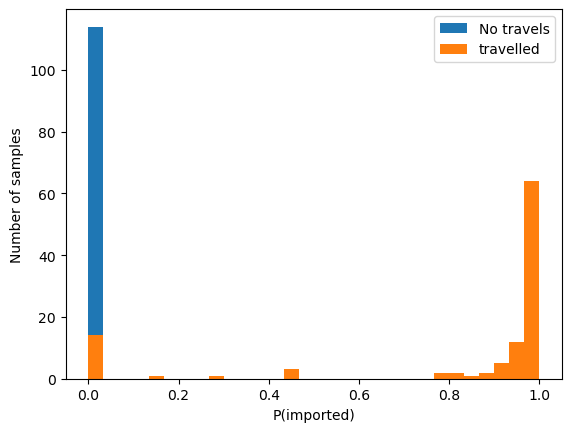

Total number of importations from probabilistic approach with imputed time and prevalence:
86.86 -- 81.18 % of cases reporting travel
41.96 % of cases with data


In [20]:
nbins = 30
plt.hist(ibd_res_meta['prob_imp_timp_pr'][react_meta], \
         nbins, range = [0,1], label = 'No travels')
plt.hist(ibd_res_meta['prob_imp_timp_pr'][travelled_ds], nbins, range = [0,1], label = 'travelled', alpha = 1)
plt.legend()
plt.xlabel("P(imported)")
plt.ylabel("Number of samples")
#plt.savefig(save_path + "P_imp_distr.png")
#plt.savefig(save_path + "P_imp_distr.pdf")
plt.show()


print("Total number of importations from probabilistic approach with imputed time and prevalence:")
total = np.sum(ibd_res_meta['prob_imp_timp_pr'][travelled_ds])
print(round(total, 2), '--', round(total/total_reported_travel*100, 2), '% of cases reporting travel')
print(round(total/total_ds_data*100, 2), '% of cases with data')


## Importation factor analysis

In [21]:
def get_import_rates_per_label(import_data, label = 'us', name = 'Health facility', \
                              save_as = None):
    """
    This method calculates and plots the fraction of imported cases 
    stratified by a given property or label. 
    
    Parameters:
    -----------
    import_data: pd.DataFrame
        Dataframe with the information of local and imported cases.
    label: str
        Name of the column on which to stratify statistics.
    name: str
        Name to plot in x-axis.
    save_as: str or None
        If specified, the plot is saved with this name. 
        
    Returns:
    --------
    Text and plot describing the statistics.
        
    """
    names = []
    totals = []
    frac_imps = []
    total_imps = []
    
    for us in import_data.loc[import_data[label].notnull(), label].unique():
        mask = import_data[label] == us
        imp_frac = np.mean(import_data.loc[mask, 'prob_imp_timp_pr'])
        total_imp = np.sum(import_data.loc[mask, 'prob_imp_timp_pr'])
        print("Importation fraction from " + us + ":\t", round(imp_frac, 3), \
              "("+ str(round(total_imp, 2)) +"/" + str(np.sum(mask)) + ")")
        names.append(us)
        totals.append(np.sum(mask))
        frac_imps.append(imp_frac)
        total_imps.append(total_imp)
        
    fig, ax1 = plt.subplots()
    fig.subplots_adjust(bottom=0.25)
    ax1.bar(range(len(names)), totals, label = 'Total cases')
    ax1.bar(range(len(names)), total_imps, label = 'Imported cases', color = 'tab:orange')
    ax1.set_xticks(range(len(names)), names, rotation = 45)
    ax1.set_ylabel("N")
    ax1.set_xlabel(name)
    ax1.legend(frameon = False, loc = 2)
    ax2 = ax1.twinx()
    ax2.plot(range(len(names)), frac_imps, lw = 2, \
             c = 'k', linestyle = '--', label = 'Importation fraction')
    ax2.set_ylabel("Imported fraction")
    ax2.set_ylim(ymin = 0, ymax = 1)
    ax2.legend(frameon = False, loc = [0.018,.75])
    if save_as is not None:
            plt.savefig(save_as)
    plt.show()

In [22]:
import_data = ibd_res_meta.loc[react_meta, ['sampleID', 'nida', 'district', \
                                            'run_id_resmark', 'run', 'us', 'age', 'sex', 'date', 'pregnancy', \
                                            'occupation', 'spec_occupation', 'travel', \
                                            'travel_prov', 'travel_dist', \
                                            'travel_days_728', 'prob_imp_timp_pr']]
import_data['season'] = 'rainy'
import_data.loc[import_data['date'] > '2022-06-01', 'season'] = 'dry'

In [23]:
#Creating a simplified version of occupation for proper statistics
import_data['occupation_simp'] = import_data['occupation']
mask_occ = import_data['occupation_simp'].notnull()
for occ in ['Domestica', 'Estudante', 'Agricultor', 'Nao aplicavel']:
    mask_occ[import_data['occupation_simp'] == occ] = False
import_data.loc[mask_occ, 'occupation_simp'] = 'Other'
#import_data.loc[import_data['occupation_simp'] == 'Nao aplicavel', 'occupation_simp'] = np.nan

## Loading lab data with parasitemia

In [24]:
parasitemia_filename = "/home/apujol/isglobal/projects/genmoz/data/GenMoz_LAB_DB_280824_HFS_TES_REACT.xlsx"
lab_data_parasitemia = pd.read_excel(parasitemia_filename)
study_mask = (lab_data_parasitemia['STUDY'] == 'HFS_2022') | (lab_data_parasitemia['STUDY'] == 'HFS22') | (lab_data_parasitemia['STUDY'] == 'TES22') | (lab_data_parasitemia['STUDY'] == 'REACT2')
lab_data_parasitemia_filt = lab_data_parasitemia[study_mask]
lab_data_parasitemia_filt = lab_data_parasitemia_filt[lab_data_parasitemia_filt['PARASITEMIA'].astype(float) > 0]
lab_data_parasitemia_filt = lab_data_parasitemia_filt[['SAMPLE.ID', 'PARASITEMIA', 'RUN', 'RUN2', 'RUN3', 'RUN4', 'RUN5']].drop_duplicates()

In [25]:
dup_samples = lab_data_parasitemia_filt.loc[lab_data_parasitemia_filt['SAMPLE.ID'].duplicated(), 'SAMPLE.ID']

In [26]:
for s in dup_samples:
    if str(s)[-2] == '.':
        mask = lab_data_parasitemia_filt['SAMPLE.ID'] == s
        mask2 = import_data['nida'] == float(s)
        if np.sum(mask2) > 0:
            print(s)
            print(lab_data_parasitemia_filt.loc[mask, 'RUN'])
            print(lab_data_parasitemia_filt.loc[mask, 'PARASITEMIA'])
            print(import_data.loc[mask2, 'sampleID'])
            print(import_data.loc[mask2, 'run'])
            print("---------------------------")
            print()

1929863.4
3173    REACT2_NextSEQ02_070723
3299    REACT2_NextSEQ01_140623
Name: RUN, dtype: object
3173     468.37
3299    4012.62
Name: PARASITEMIA, dtype: object
263870    N1929863_4_S127_L001
Name: sampleID, dtype: object
263870    REACT_R1
Name: run, dtype: object
---------------------------

1941448.5
3211    REACT2_NextSEQ01_140623
3376    REACT2_NextSEQ02_070723
Name: RUN, dtype: object
3211    109059.44
3376        31.32
Name: PARASITEMIA, dtype: object
263602    N1941448_5_S76_L001
Name: sampleID, dtype: object
263602    REACT_R1
Name: run, dtype: object
---------------------------

1974024.9
3142    REACT2_NextSEQ01_140623
3495    REACT2_NextSEQ01_140623
Name: RUN, dtype: object
3142    14755.7
3495    5283.82
Name: PARASITEMIA, dtype: object
263711    N1974024_9a_S34_L001
Name: sampleID, dtype: object
263711    REACT_R1
Name: run, dtype: object
---------------------------

1941549.9
3371    REACT2_NextSEQ01_140623
3535    REACT2_NextSEQ01_140623
Name: RUN, dtype: object
3371

In [27]:
#In case of duplicate samples, we choose the highest parasitemia. 
#We checked this gets the ones we really used
dup_samples = lab_data_parasitemia_filt.loc[lab_data_parasitemia_filt['SAMPLE.ID'].duplicated(), 'SAMPLE.ID']
for s in dup_samples:
    if str(s)[-2] == '.':
        mask = lab_data_parasitemia_filt['SAMPLE.ID'] == s
        max_density = np.max(lab_data_parasitemia_filt.loc[mask, 'PARASITEMIA'].astype(float))
        lab_data_parasitemia_filt.loc[mask, 'PARASITEMIA'] = max_density
        
lab_data_parasitemia_filt = lab_data_parasitemia_filt[['SAMPLE.ID', 'PARASITEMIA']].drop_duplicates()

### Merging parasitemia info

In [28]:
import_data['nida_obj'] = import_data['nida'].astype(str).astype(object)
import_data = pd.merge(import_data, lab_data_parasitemia_filt, left_on = 'nida_obj', right_on = 'SAMPLE.ID', how = 'left')
import_data['logdens'] = np.log10(import_data['PARASITEMIA'].astype(float))

### loading and merging COI data

In [31]:
data_path  = "/home/apujol/isglobal/projects/genmoz/data/Pipeline_Results/moire/"
eff_coi = pd.read_csv(data_path + "eff_coi.csv")
naive_coi = pd.read_csv(data_path + "naive_coi.csv")

In [32]:
import_data = pd.merge(import_data, eff_coi[['sample_id', 'post_effective_coi_mean']], \
         left_on = 'sampleID', right_on = 'sample_id', how = 'left')
import_data['eCOI'] = import_data['post_effective_coi_mean']
import_data['polyclonal'] = pd.Series(import_data['post_effective_coi_mean'] > 1.1, dtype = int)
import_data = import_data.rename(columns = {'sample_id_x' : 'sample_id'})
import_data = pd.merge(import_data, naive_coi[['sample_id', 'naive_coi', 'prob_polyclonal']], \
         left_on = 'sampleID', right_on = 'sample_id', how = 'left')
import_data['naive_polyclonal'] = pd.Series(import_data['naive_coi'] > 1, dtype = int)

KeyError: 'post_effective_coi_mean'

### Defining categorical ages

In [33]:
import_data['age_cat'] = pd.Series([])
import_data.loc[import_data['age'] >= 18, 'age_cat'] = 'Adult'
import_data.loc[import_data['age'] < 18, 'age_cat'] = 'Minor'

### Factor analysis

In [34]:
imported = import_data['prob_imp_timp_pr'] > .5
import_data['imported'] = pd.Series(dtype = int)
import_data.loc[imported, 'imported'] = 1
import_data.loc[np.invert(imported), 'imported'] = 0

In [35]:
factor_list = ['district', 'season', 'us', 'sex', 'pregnancy', 'occupation_simp', \
               'travel_prov', 'age_cat', 'logdens', 'eCOI', 'polyclonal', 'naive_coi', \
               'prob_polyclonal', 'naive_polyclonal']

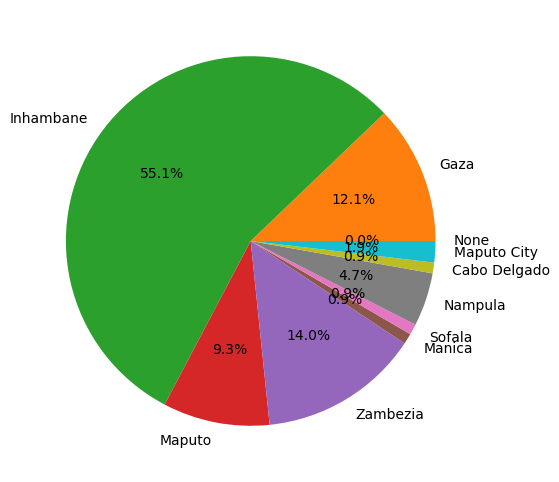

Number and fraction of cases:
None:         0	0.0%
Gaza:         13	12.1%
Inhambane:    59	55.1%
Maputo:       10	9.3%
Zambezia:     15	14.0%
Manica:       1	0.9%
Sofala:       1	0.9%
Nampula:      5	4.7%
Cabo Delgado: 1	0.9%
Maputo City:  2	1.9%


In [36]:
make_pie(import_data.loc[import_data['travel'] == 1, "travel_prov"], verbose = True, ignore_null = False)


district

Local


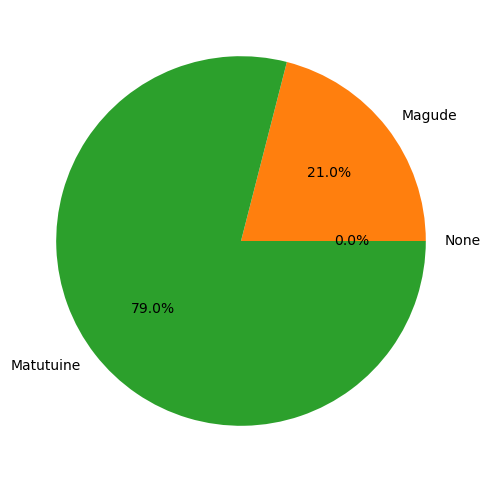

Number and fraction of cases:
None:      0	0.0%
Magude:    25	21.0%
Matutuine: 94	79.0%

Imported


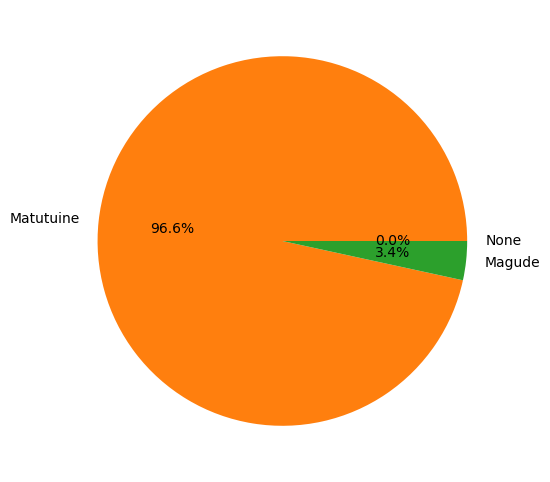

Number and fraction of cases:
None:      0	0.0%
Matutuine: 85	96.6%
Magude:    3	3.4%

season

Local


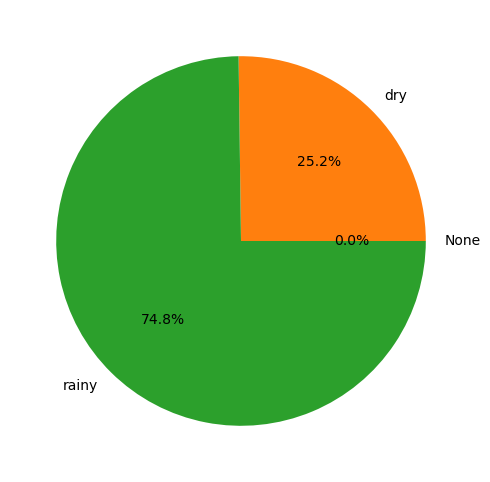

Number and fraction of cases:
None:  0	0.0%
dry:   30	25.2%
rainy: 89	74.8%

Imported


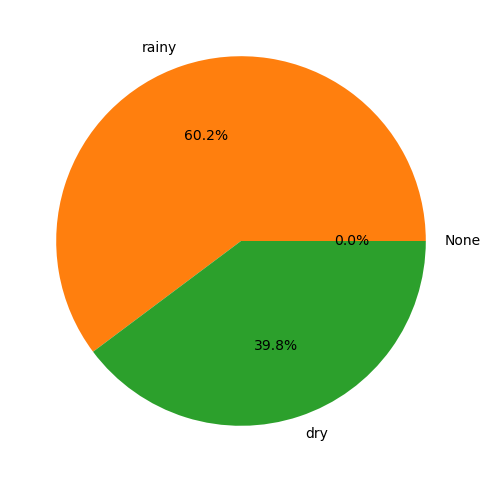

Number and fraction of cases:
None:  0	0.0%
rainy: 53	60.2%
dry:   35	39.8%

us

Local


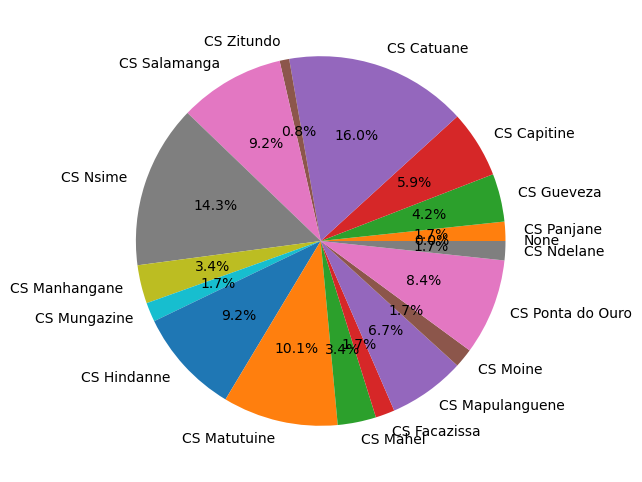

Number and fraction of cases:
None:             0	0.0%
CS Panjane:       2	1.7%
CS Gueveza:       5	4.2%
CS Capitine:      7	5.9%
CS Catuane:       19	16.0%
CS Zitundo:       1	0.8%
CS Salamanga:     11	9.2%
CS Nsime:         17	14.3%
CS Manhangane:    4	3.4%
CS Mungazine:     2	1.7%
CS Hindanne:      11	9.2%
CS Matutuine:     12	10.1%
CS Mahel:         4	3.4%
CS Facazissa:     2	1.7%
CS Mapulanguene:  8	6.7%
CS Moine:         2	1.7%
CS Ponta do Ouro: 10	8.4%
CS Ndelane:       2	1.7%

Imported


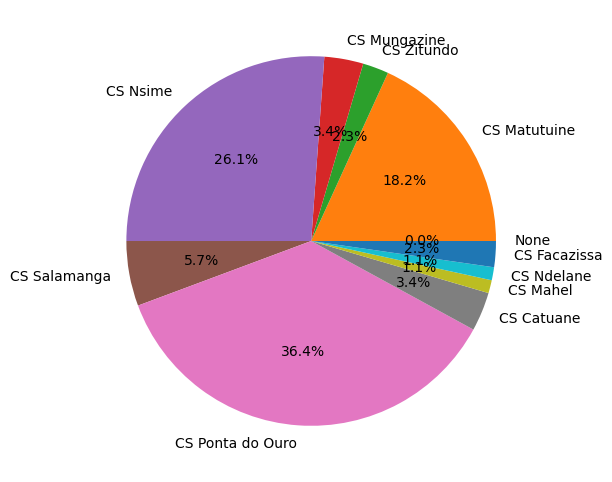

Number and fraction of cases:
None:             0	0.0%
CS Matutuine:     16	18.2%
CS Zitundo:       2	2.3%
CS Mungazine:     3	3.4%
CS Nsime:         23	26.1%
CS Salamanga:     5	5.7%
CS Ponta do Ouro: 32	36.4%
CS Catuane:       3	3.4%
CS Mahel:         1	1.1%
CS Ndelane:       1	1.1%
CS Facazissa:     2	2.3%

sex

Local


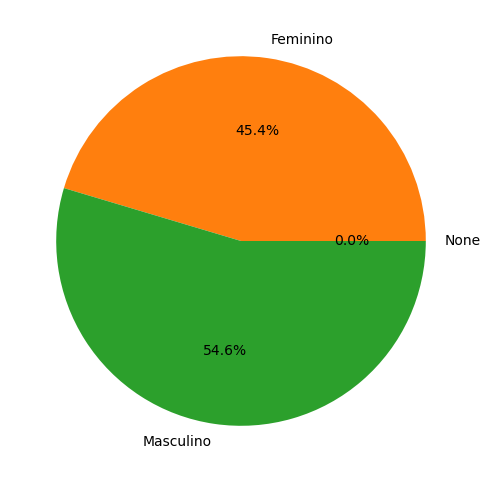

Number and fraction of cases:
None:      0	0.0%
Feminino:  54	45.4%
Masculino: 65	54.6%

Imported


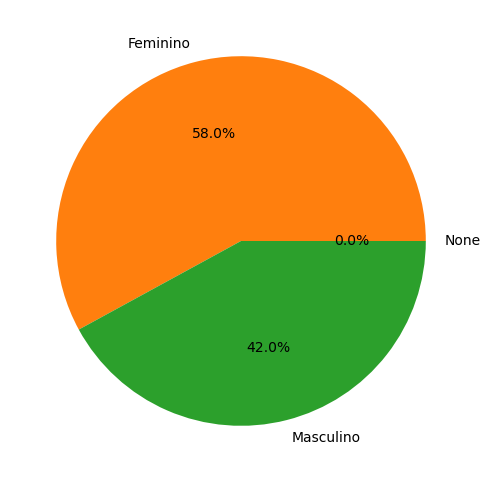

Number and fraction of cases:
None:      0	0.0%
Feminino:  51	58.0%
Masculino: 37	42.0%

pregnancy

Local


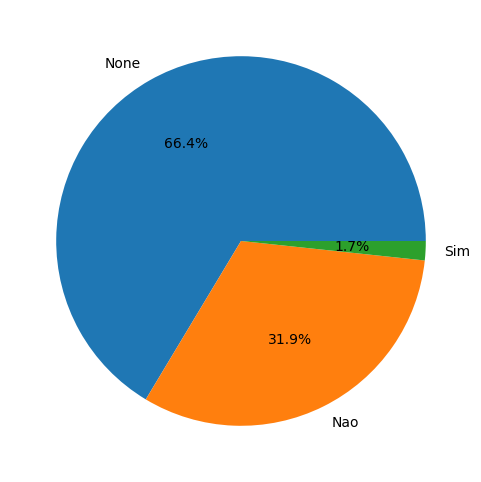

Number and fraction of cases:
None: 79	66.4%
Nao:  38	31.9%
Sim:  2	1.7%

Imported


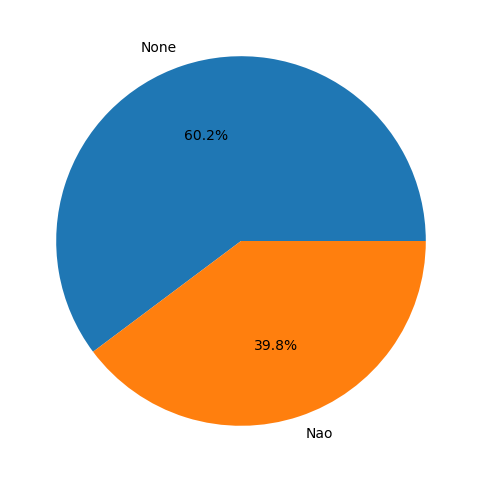

Number and fraction of cases:
None: 53	60.2%
Nao:  35	39.8%

occupation_simp

Local


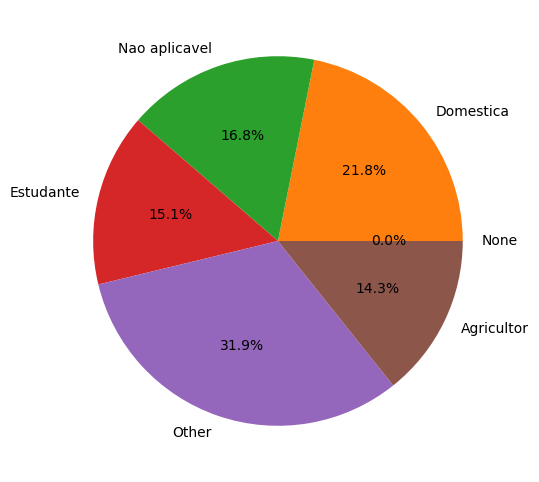

Number and fraction of cases:
None:          0	0.0%
Domestica:     26	21.8%
Nao aplicavel: 20	16.8%
Estudante:     18	15.1%
Other:         38	31.9%
Agricultor:    17	14.3%

Imported


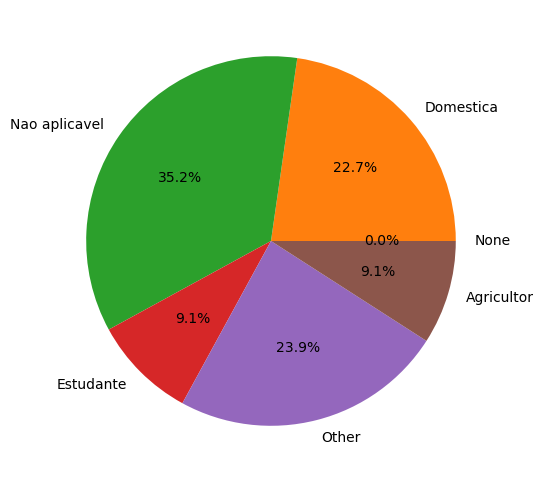

Number and fraction of cases:
None:          0	0.0%
Domestica:     20	22.7%
Nao aplicavel: 31	35.2%
Estudante:     8	9.1%
Other:         21	23.9%
Agricultor:    8	9.1%

travel_prov

Local


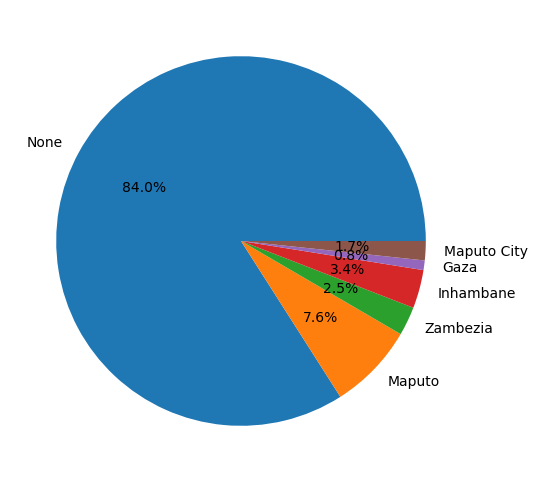

Number and fraction of cases:
None:        100	84.0%
Maputo:      9	7.6%
Zambezia:    3	2.5%
Inhambane:   4	3.4%
Gaza:        1	0.8%
Maputo City: 2	1.7%

Imported


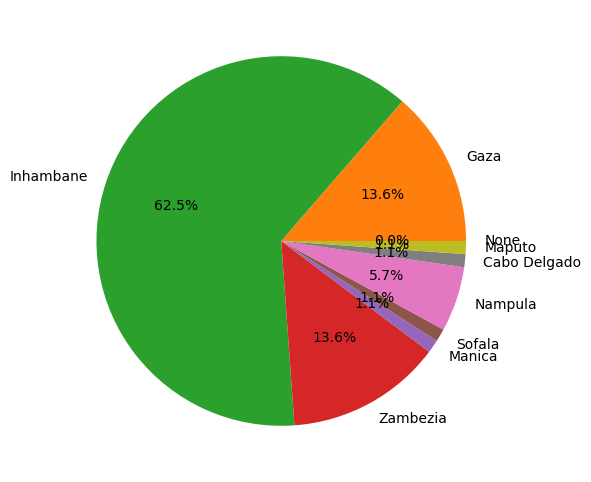

Number and fraction of cases:
None:         0	0.0%
Gaza:         12	13.6%
Inhambane:    55	62.5%
Zambezia:     12	13.6%
Manica:       1	1.1%
Sofala:       1	1.1%
Nampula:      5	5.7%
Cabo Delgado: 1	1.1%
Maputo:       1	1.1%

age_cat

Local


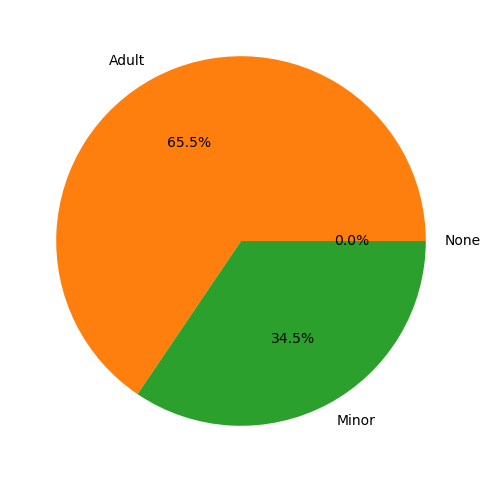

Number and fraction of cases:
None:  0	0.0%
Adult: 78	65.5%
Minor: 41	34.5%

Imported


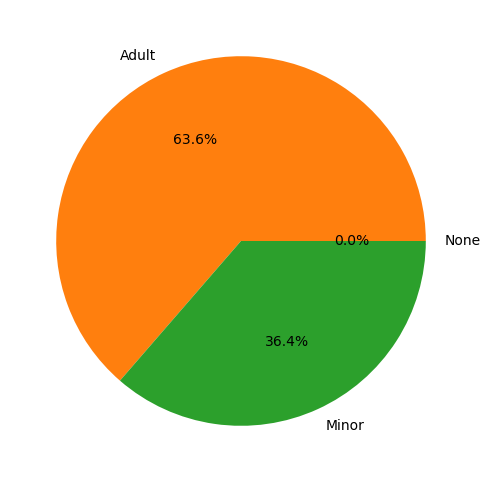

Number and fraction of cases:
None:  0	0.0%
Adult: 56	63.6%
Minor: 32	36.4%

logdens

Local


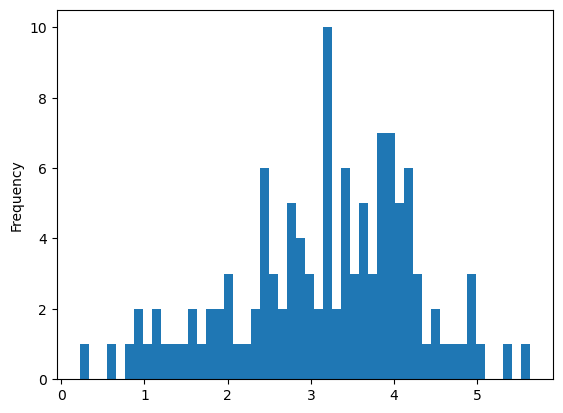


Imported


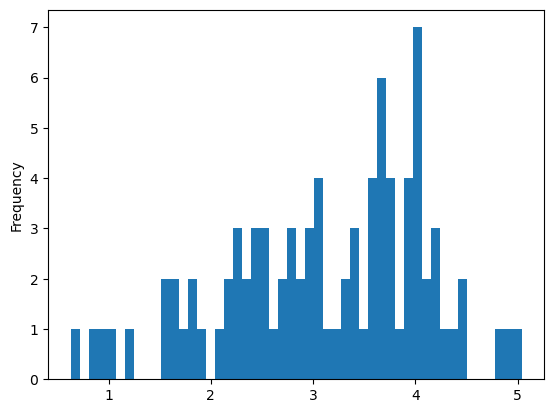


eCOI

Local


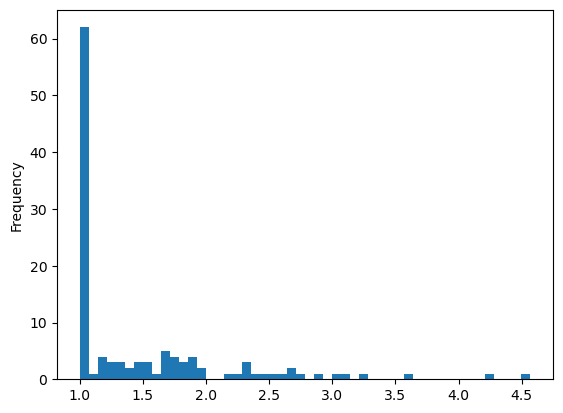


Imported


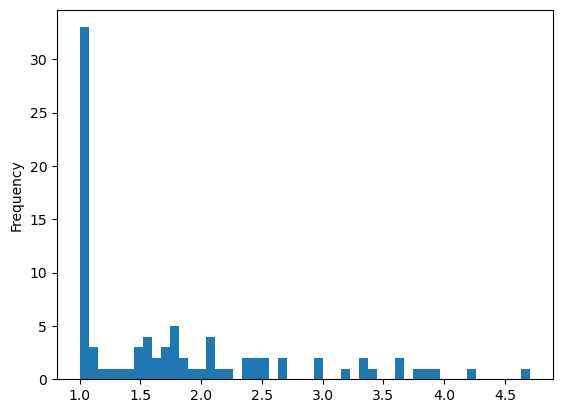


polyclonal

Local


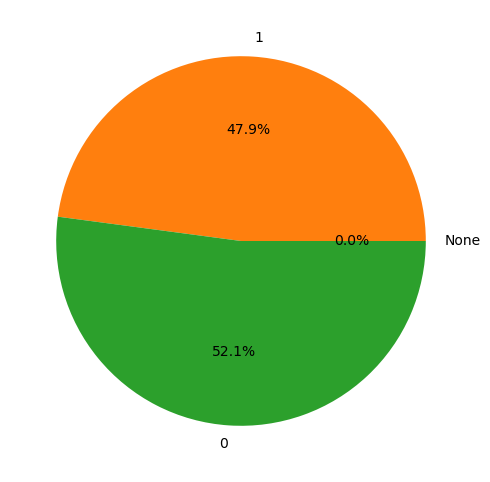

Number and fraction of cases:
None: 0	0.0%
1:    57	47.9%
0:    62	52.1%

Imported


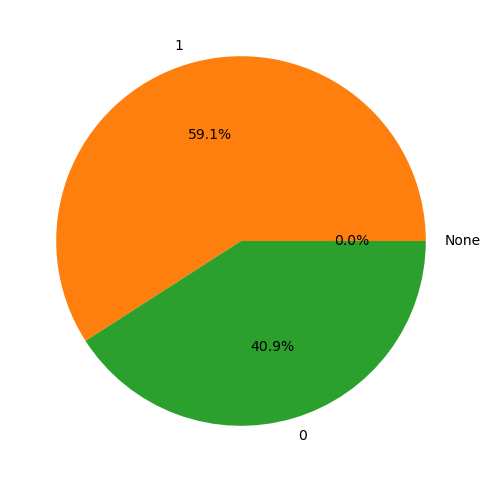

Number and fraction of cases:
None: 0	0.0%
1:    52	59.1%
0:    36	40.9%

naive_coi

Local


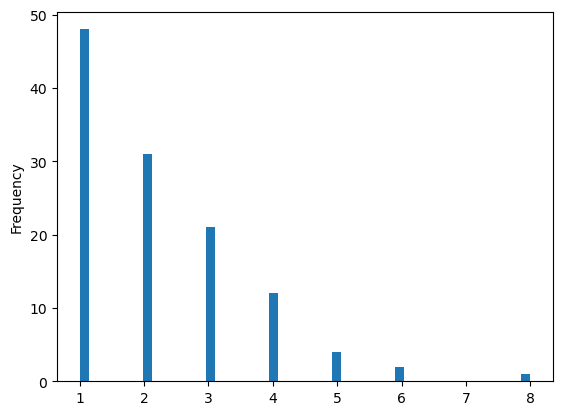


Imported


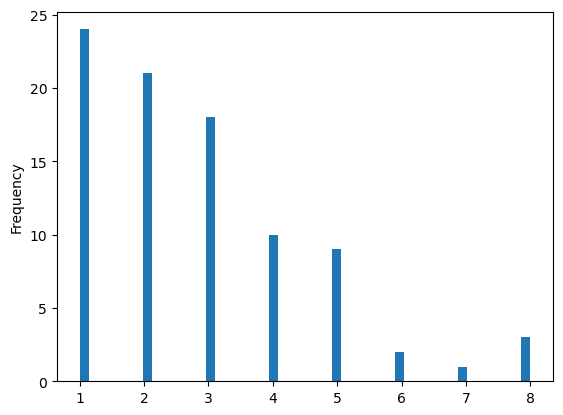


prob_polyclonal

Local


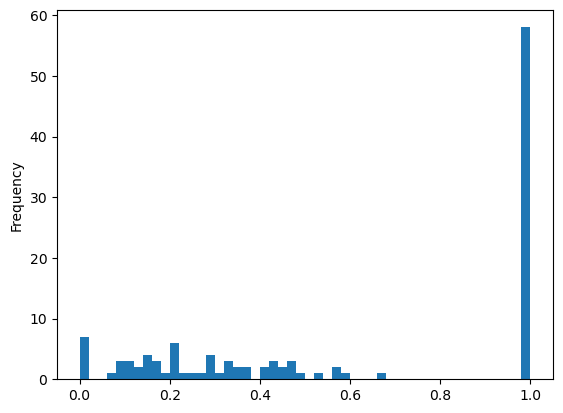


Imported


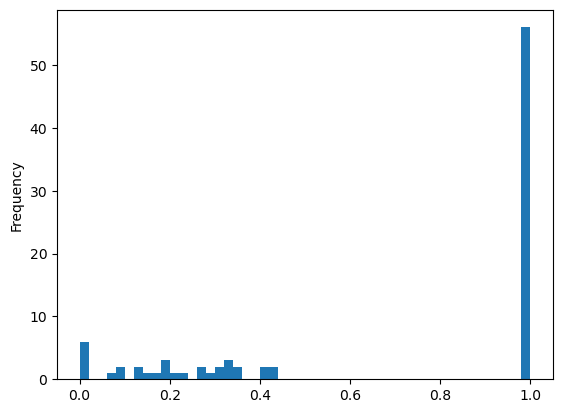


naive_polyclonal

Local


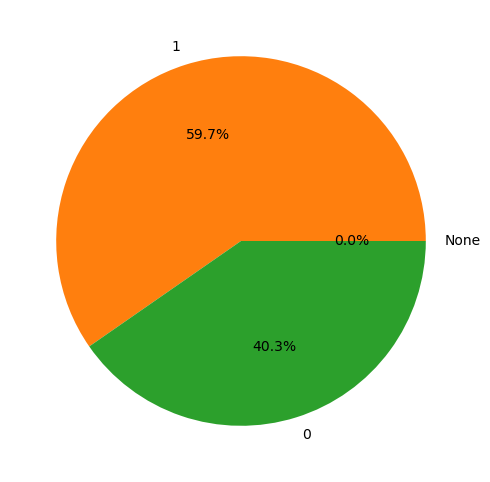

Number and fraction of cases:
None: 0	0.0%
1:    71	59.7%
0:    48	40.3%

Imported


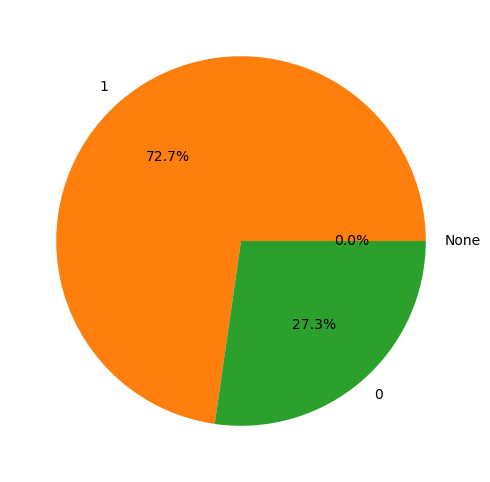

Number and fraction of cases:
None: 0	0.0%
1:    64	72.7%
0:    24	27.3%


In [37]:
for variable in factor_list:
    print()
    print(variable)
    print()
    print("Local")
    if variable in ['age', 'logdens', 'eCOI', 'naive_coi', 'prob_polyclonal']:
        make_hist(import_data.loc[np.invert(imported), variable])
    else:
        make_pie(import_data.loc[np.invert(imported), variable], verbose = True, ignore_null = False)
    print()
    print("Imported")
    if variable in ['age', 'logdens', 'eCOI', 'naive_coi', 'prob_polyclonal']:
        make_hist(import_data.loc[imported, variable])
    else:
        make_pie(import_data.loc[imported, variable], verbose = True, ignore_null = False)

## Statistical tests

### Univariate Chi-square and T-test 

In [112]:
#travel factor analysis
all_p = []
all_tables = []
for var in factor_list:
    print()
    print(var)
    if var in ['district', 'season', 'us', 'sex', 'age_cat', 'pregnancy', 'occupation_simp', 'polyclonal', 'naive_polyclonal']:
        if var == 'occupation_simpl': 
            mask = (import_data[var] != 'Nao aplicavel')&(import_data[var] != 'Outro (Especificar)')
            table_var_imp = tables.labels_2d(import_data[mask], var, 'travel')
        else:
            table_var_imp = tables.labels_2d(import_data, var, 'travel')
        print(table_var_imp)
        stat, p, dof, expected = chi2_contingency(table_var_imp)
    elif var != 'travel_prov': 
        x_var = np.array(import_data.loc[import_data['travel'] == 2, var])
        y_var = np.array(import_data.loc[import_data['travel'] == 1, var])
        print("Mean (SD) " + var + " no travel:", np.mean(x_var), "(", np.std(x_var), ")")
        print("Mean (SD) " + var + " travel:", np.mean(y_var), "(", np.std(y_var), ")")
        print("Mean (95CI) " + var + " no travel:", np.mean(x_var), "(", np.percentile(x_var, 2.5), ",", np.percentile(x_var, 97.5), ")")
        print("Mean (95CI) " + var + " travel:", np.mean(y_var), "(", np.percentile(y_var, 2.5), ",", np.percentile(y_var, 97.5), ")")
        stat, p = ttest_ind(x_var, y_var)
    else: 
        continue
    print("p-value:", p)
    all_p.append(p)
    all_tables.append(table_var_imp)
    print()


district
           2.0  1.0
Magude      25    3
Matutuine   75  104
p-value: 8.092245338263305e-06


season
       1.0  2.0
dry     41   24
rainy   66   76
p-value: 0.03863010878777855


us
                   2.0   1.0
CS Panjane         2.0   0.0
CS Matutuine      10.0  18.0
CS Gueveza         5.0   0.0
CS Capitine        7.0   0.0
CS Catuane        18.0   4.0
CS Zitundo         0.0   3.0
CS Salamanga       7.0   9.0
CS Nsime          13.0  27.0
CS Manhangane      4.0   0.0
CS Mungazine       0.0   5.0
CS Hindanne       10.0   1.0
CS Mahel           4.0   1.0
CS Facazissa       2.0   2.0
CS Mapulanguene    8.0   0.0
CS Moine           2.0   0.0
CS Ponta do Ouro   7.0  35.0
CS Ndelane         1.0   2.0
p-value: 1.430845594474089e-10


sex
           1.0  2.0
Feminino    59   46
Masculino   48   54
p-value: 0.23986429608932322


pregnancy
      1.0   2.0
Nao  42.0  31.0
Sim   0.0   2.0
p-value: 0.3706741606854993


occupation_simp
               1.0  2.0
Domestica       27   19
Nao ap

8.092245338263305e-06 -> 5.259959469871148e-05
0.03863010878777855 -> 0.055799046026791234
1.430845594474089e-10 -> 1.8600992728163156e-09
0.23986429608932322 -> 0.31182358491612017
0.3706741606854993 -> 0.43806946262831736
0.02991312688353554 -> 0.04860883118574525
0.44987514890285285 -> 0.4873647446447572
0.5861042004271897 -> 0.5861042004271897
0.006777953493326106 -> 0.022028348853309843
0.02306764093212834 -> 0.04496782129695377
0.0032702046161584264 -> 0.014170886670019847
0.014583464108569739 -> 0.03791700668228132
0.024213442236821262 -> 0.04496782129695377


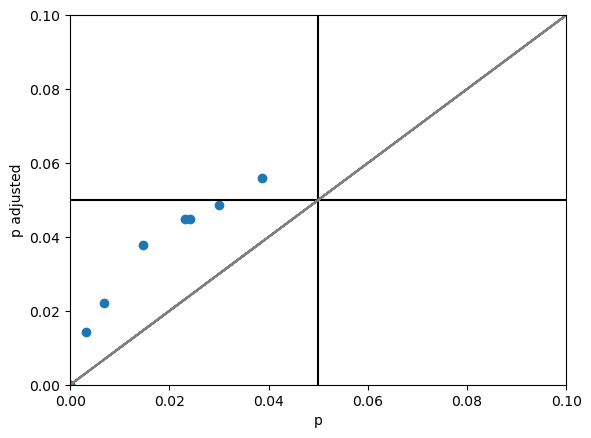

In [33]:
p_corr1 = statsmodels.stats.multitest.fdrcorrection(np.array(all_p), alpha=0.05, method='indep', is_sorted=False)
for i in range(len(all_p)):
    print(all_p[i], "->", p_corr1[1][i])
plt.scatter(np.array(all_p), p_corr1[1])
plt.hlines(.05, 0,1, color = 'k')
plt.vlines(.05, 0,1, color = 'k')
plt.plot(np.array(all_p)[:-3], np.array(all_p)[:-3], c = 'tab:grey')
plt.xlabel("p")
plt.ylabel("p adjusted")
plt.xlim(0,.1)
plt.ylim(0,.1)
plt.show()

In [116]:
#importation factor analysis
all_p = []
all_tables = []
for var in factor_list:
    print()
    print(var)
    if var in ['district', 'season', 'us', 'sex', 'age_cat', 'pregnancy', 'occupation_simp', 'travel_prov', 'polyclonal', 'naive_polyclonal']:
        if var == 'occupation_simp': 
            mask = (import_data[var] != 'Nao aplicavel')&(import_data[var] != 'Outro (Especificar)')
            table_var_imp = tables.labels_2d(import_data[mask], var, 'imported')
        else:
            table_var_imp = tables.labels_2d(import_data, var, 'imported')
        print(table_var_imp)
        stat, p, dof, expected = chi2_contingency(table_var_imp)
    else: 
        x_var = np.array(import_data.loc[import_data['imported'] == 0, var])
        y_var = np.array(import_data.loc[import_data['imported'] == 1, var])
        print("Mean (SD) " + var + " local:", np.mean(x_var), "(", np.std(x_var), ")")
        print("Mean (SD) " + var + " imported:", np.mean(y_var), "(", np.std(y_var), ")")
        print("Mean (95CI) " + var + " no travel:", np.mean(x_var), "(", np.percentile(x_var, 2.5), ",", np.percentile(x_var, 97.5), ")")
        print("Mean (95CI) " + var + " travel:", np.mean(y_var), "(", np.percentile(y_var, 2.5), ",", np.percentile(y_var, 97.5), ")")
        stat, p = ttest_ind(x_var, y_var)
    print("p-value:", p)
    all_p.append(p)
    all_tables.append(table_var_imp)
    print()


district
           0.0  1.0
Magude      25    3
Matutuine   94   85
p-value: 0.0005512481779973052


season
       1.0  0.0
dry     35   30
rainy   53   89
p-value: 0.03750223996829825


us
                   0.0   1.0
CS Panjane         2.0   0.0
CS Matutuine      12.0  16.0
CS Gueveza         5.0   0.0
CS Capitine        7.0   0.0
CS Catuane        19.0   3.0
CS Zitundo         1.0   2.0
CS Salamanga      11.0   5.0
CS Nsime          17.0  23.0
CS Manhangane      4.0   0.0
CS Mungazine       2.0   3.0
CS Hindanne       11.0   0.0
CS Mahel           4.0   1.0
CS Facazissa       2.0   2.0
CS Mapulanguene    8.0   0.0
CS Moine           2.0   0.0
CS Ponta do Ouro  10.0  32.0
CS Ndelane         2.0   1.0
p-value: 6.35685949565557e-08


sex
           0.0  1.0
Feminino    54   51
Masculino   65   37
p-value: 0.09922952648523646


pregnancy
      0.0   1.0
Nao  38.0  35.0
Sim   2.0   0.0
p-value: 0.5335809276213306


occupation_simp
            0.0  1.0
Domestica    26   20
Estudante    

0.0005512481779973052 -> 0.0025724914973207576
0.03750223996829825 -> 0.08750522659269591
6.35685949565557e-08 -> 4.449801646958899e-07
0.09922952648523646 -> 0.16039442552471042
0.5335809276213306 -> 0.6791029987907844
0.6654303328418967 -> 0.6928771050841473
1.318067990223598e-08 -> 1.8452951863130374e-07
0.6024909501639242 -> 0.6928771050841473
0.6928771050841473 -> 0.6928771050841473
0.007054727579292342 -> 0.019753237222018556
0.14608167444890777 -> 0.20451434422847087
0.004296293513433246 -> 0.015037027297016363
0.10311070212302813 -> 0.16039442552471042
0.07134888540160862 -> 0.14269777080321724


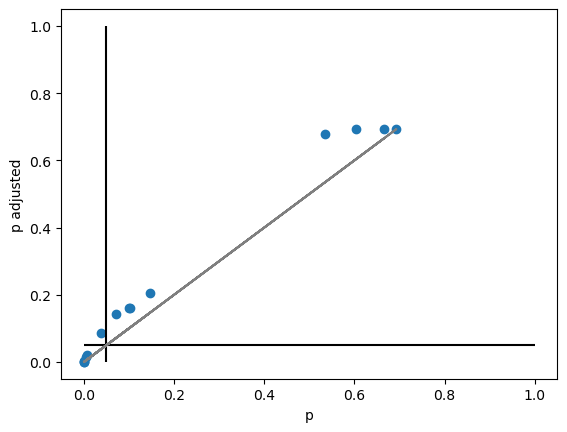

In [35]:
p_corr1 = statsmodels.stats.multitest.fdrcorrection(np.array(all_p), alpha=0.05, method='indep', is_sorted=False)
for i in range(len(all_p)):
    print(all_p[i], "->", p_corr1[1][i])
plt.scatter(all_p, p_corr1[1])
plt.hlines(.05, 0,1, color = 'k')
plt.vlines(.05, 0,1, color = 'k')
plt.plot(all_p, all_p, c = 'tab:grey')
plt.xlabel("p")
plt.ylabel("p adjusted")
plt.show()

In [118]:
#importation factor analysis conditional to travel
mask_trav = import_data['travel'] == 1
all_p = []
all_tables = []
for var in factor_list:
    print()
    print(var)
    if var in ['district', 'season', 'us', 'sex', 'age_cat', 'pregnancy', 'occupation_simp', 'travel_prov', 'polyclonal', 'naive_polyclonal']:
        if var == 'occupation_simp': 
            mask = mask_trav&(import_data[var] != 'Nao aplicavel')&(import_data[var] != 'Outro (Especificar)')
            table_var_imp = tables.labels_2d(import_data[mask], var, 'imported')
        else:
            table_var_imp = tables.labels_2d(import_data[mask_trav], var, 'imported')
        print(table_var_imp)
        stat, p, dof, expected = chi2_contingency(table_var_imp)
    else: 
        used_data = import_data[mask_trav]
        x_var = np.array(used_data.loc[used_data['imported'] == 0, var])
        y_var = np.array(used_data.loc[used_data['imported'] == 1, var])
        print("Mean (SD) " + var + " local:", np.mean(x_var), "(", np.std(x_var), ")")
        print("Mean (SD) " + var + " imported:", np.mean(y_var), "(", np.std(y_var), ")")
        print("Mean (95CI) " + var + " local:", np.mean(x_var), "(", np.percentile(x_var, 2.5), ",", np.percentile(x_var, 97.5), ")")
        print("Mean (95CI) " + var + " imported:", np.mean(y_var), "(", np.percentile(y_var, 2.5), ",", np.percentile(y_var, 97.5), ")")
        stat, p = ttest_ind(x_var, y_var)
    print("p-value:", p)
    all_p.append(p)
    all_tables.append(table_var_imp)
    print()



district
            1.0   0.0
Matutuine  85.0  19.0
Magude      3.0   0.0
p-value: 0.960021847421197


season
       1.0  0.0
rainy   53   13
dry     35    6
p-value: 0.6846943100095586


us
                   1.0  0.0
CS Matutuine      16.0  2.0
CS Zitundo         2.0  1.0
CS Salamanga       5.0  4.0
CS Nsime          23.0  4.0
CS Mungazine       3.0  2.0
CS Hindanne        0.0  1.0
CS Ponta do Ouro  32.0  3.0
CS Ndelane         1.0  1.0
CS Catuane         3.0  1.0
CS Mahel           1.0  0.0
CS Facazissa       2.0  0.0
p-value: 0.09528469208771696


sex
           1.0  0.0
Feminino    51    8
Masculino   37   11
p-value: 0.31470581914063944


pregnancy
     0.0  1.0
Nao    7   35
p-value: 1.0


occupation_simp
            1.0  0.0
Domestica    20    7
Estudante     8    1
Other        21    6
Agricultor    8    2
p-value: 0.827704785144318


travel_prov
               1.0  0.0
Gaza          12.0  1.0
Inhambane     55.0  4.0
Maputo         1.0  9.0
Zambezia      12.0  3.0
Manica    

0.960021847421197 -> 1.0
0.6846943100095586 -> 1.0
0.09528469208771696 -> 0.6669928446140188
0.31470581914063944 -> 1.0
1.0 -> 1.0
0.827704785144318 -> 1.0
1.318067990223598e-08 -> 1.8452951863130374e-07
0.8565034713709851 -> 1.0
0.9109498704405102 -> 1.0
0.45960994398753807 -> 1.0
0.6197053225421345 -> 1.0
0.49482229478107076 -> 1.0
0.4725543310414707 -> 1.0
1.0 -> 1.0


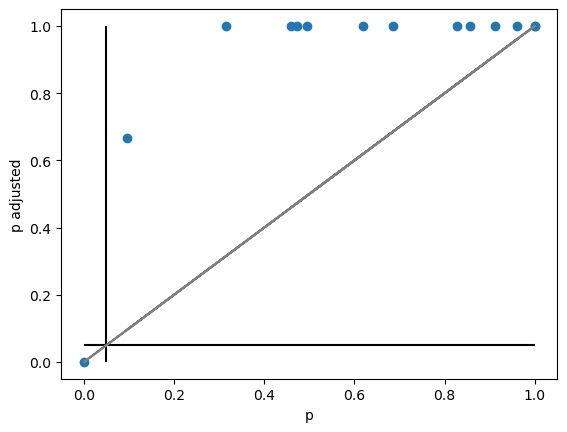

In [37]:
p_corr1 = statsmodels.stats.multitest.fdrcorrection(np.array(all_p), alpha=0.05, method='indep', is_sorted=False)
for i in range(len(all_p)):
    print(all_p[i], "->", p_corr1[1][i])
plt.scatter(all_p, p_corr1[1])
plt.hlines(.05, 0,1, color = 'k')
plt.vlines(.05, 0,1, color = 'k')
plt.plot(all_p, all_p, c = 'tab:grey')
plt.xlabel("p")
plt.ylabel("p adjusted")
plt.show()


district

Importation fraction from Magude:	 0.104 (2.91/28)
Importation fraction from Matutuine:	 0.469 (83.95/179)


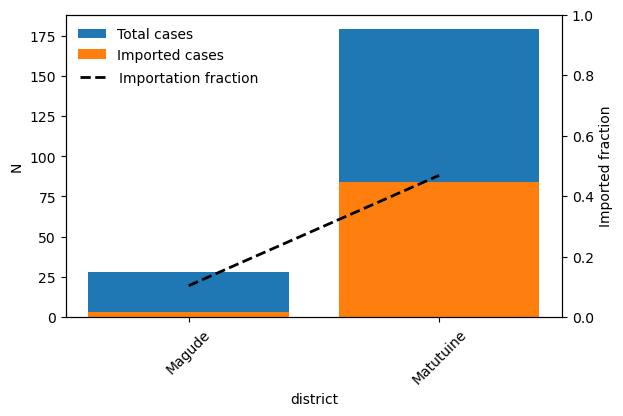



season

Importation fraction from dry:	 0.524 (34.08/65)
Importation fraction from rainy:	 0.372 (52.78/142)


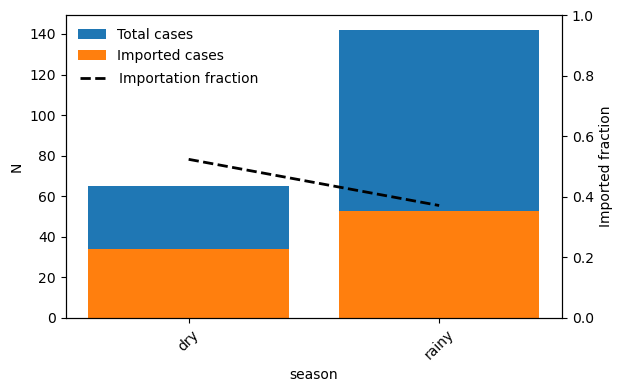



us

Importation fraction from CS Panjane:	 0.0 (0.0/2)
Importation fraction from CS Matutuine:	 0.563 (15.78/28)
Importation fraction from CS Gueveza:	 0.0 (0.0/5)
Importation fraction from CS Capitine:	 0.0 (0.0/7)
Importation fraction from CS Catuane:	 0.133 (2.93/22)
Importation fraction from CS Zitundo:	 0.645 (1.93/3)
Importation fraction from CS Salamanga:	 0.306 (4.89/16)
Importation fraction from CS Nsime:	 0.571 (22.84/40)
Importation fraction from CS Manhangane:	 0.0 (0.0/4)
Importation fraction from CS Mungazine:	 0.676 (3.38/5)
Importation fraction from CS Hindanne:	 0.04 (0.44/11)
Importation fraction from CS Mahel:	 0.196 (0.98/5)
Importation fraction from CS Facazissa:	 0.483 (1.93/4)
Importation fraction from CS Mapulanguene:	 0.0 (0.0/8)
Importation fraction from CS Moine:	 0.0 (0.0/2)
Importation fraction from CS Ponta do Ouro:	 0.734 (30.83/42)
Importation fraction from CS Ndelane:	 0.309 (0.93/3)


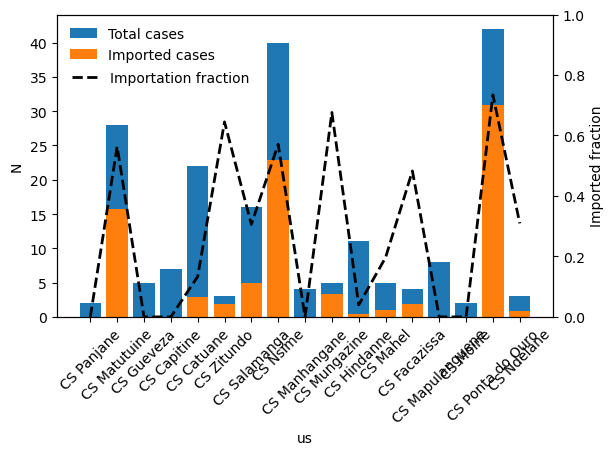



sex

Importation fraction from Feminino:	 0.473 (49.65/105)
Importation fraction from Masculino:	 0.365 (37.21/102)


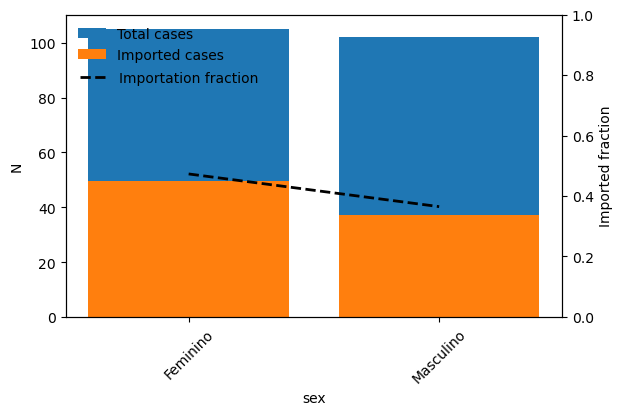



pregnancy

Importation fraction from Nao:	 0.466 (34.0/73)
Importation fraction from Sim:	 0.0 (0.0/2)


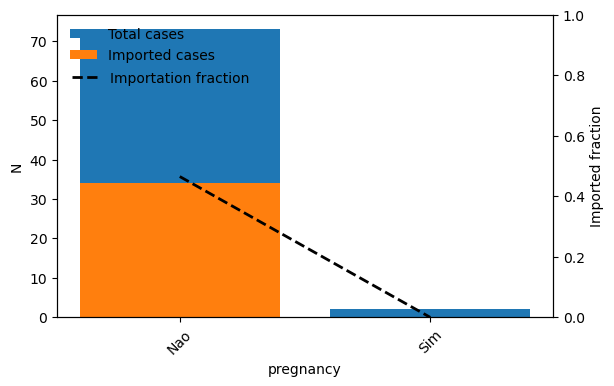



occupation_simp

Importation fraction from Domestica:	 0.421 (19.36/46)
Importation fraction from Nao aplicavel:	 0.594 (30.3/51)
Importation fraction from Estudante:	 0.295 (7.68/26)
Importation fraction from Other:	 0.365 (21.56/59)
Importation fraction from Agricultor:	 0.318 (7.96/25)


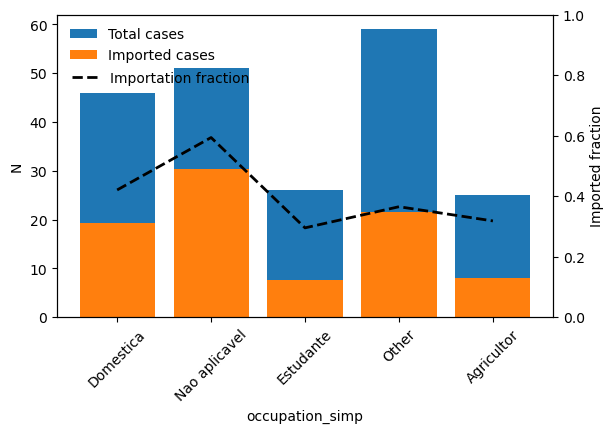



travel_prov

Importation fraction from Gaza:	 0.87 (11.31/13)
Importation fraction from Inhambane:	 0.9 (53.09/59)
Importation fraction from Maputo:	 0.273 (2.73/10)
Importation fraction from Zambezia:	 0.792 (11.88/15)
Importation fraction from Manica:	 0.883 (0.88/1)
Importation fraction from Sofala:	 0.985 (0.99/1)
Importation fraction from Nampula:	 0.997 (4.98/5)
Importation fraction from Cabo Delgado:	 0.998 (1.0/1)
Importation fraction from Maputo City:	 0.0 (0.0/2)


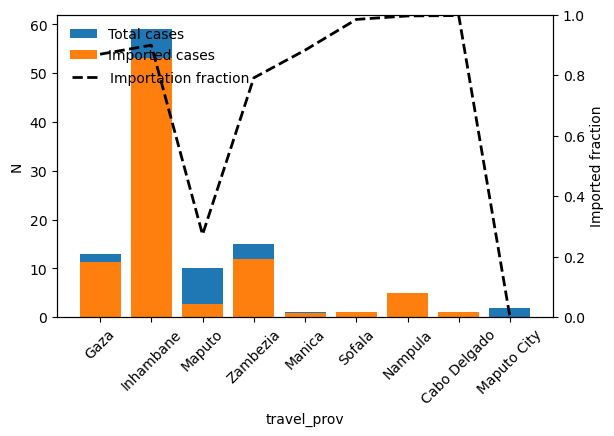



age_cat

Importation fraction from Adult:	 0.415 (55.63/134)
Importation fraction from Minor:	 0.428 (31.23/73)


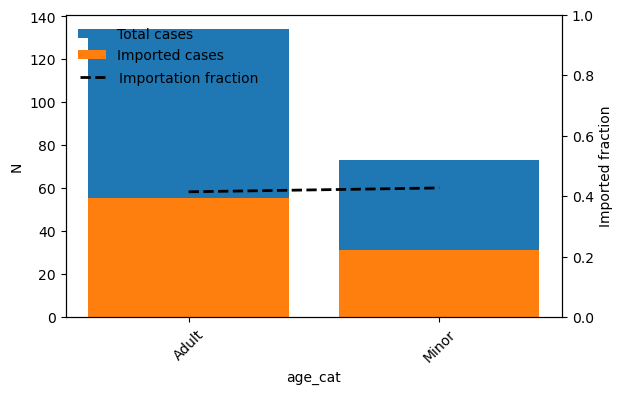



polyclonal



TypeError: can only concatenate str (not "numpy.int64") to str

In [44]:
save_path = "/home/apujol/isglobal/manuscripts/importation_relatedness/figs/"
for variable in factor_list:
    if variable not in ['age', 'logdens', 'eCOI']:
        print()
        print(variable)
        print()
        get_import_rates_per_label(import_data, label = variable, name = variable, \
                                  save_as = save_path + "factor_imp_" + variable + ".pdf")
        print()

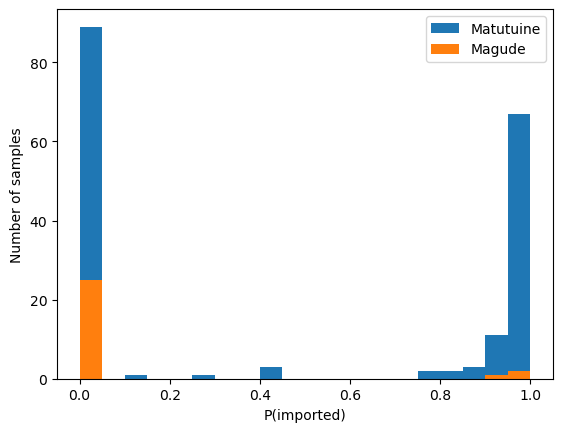

Magude importation fraction: 0.10397780796623834
Magude travel fraction: 0.1071428571428572
Matutuine importation fraction: 0.4689949326508745
Matutuine travel fraction: 0.5810055865921788


In [48]:
plt.hist(import_data.loc[import_data['district'] == 'Matutuine', 'prob_imp_timp_pr'], \
         20, range = [0,1], label = 'Matutuine', alpha = 1)
plt.hist(import_data.loc[import_data['district'] == 'Magude', 'prob_imp_timp_pr'], \
         20, range = [0,1], label = 'Magude', alpha = 1)
plt.legend()
plt.xlabel("P(imported)")
plt.ylabel("Number of samples")
plt.savefig(save_path + "P_imp_distr.png")
plt.savefig(save_path + "P_imp_distr.pdf")
plt.show()

print("Magude importation fraction:", np.mean(import_data.loc[import_data['district'] == 'Magude', 'prob_imp_timp_pr']))
print("Magude travel fraction:", 2 - np.mean(import_data.loc[import_data['district'] == 'Magude', 'travel']))
print("Matutuine importation fraction:", np.mean(import_data.loc[import_data['district'] == 'Matutuine', 'prob_imp_timp_pr']))
print("Matutuine travel fraction:", 2 - np.mean(import_data.loc[import_data['district'] == 'Matutuine', 'travel']))

## Fraction of cases from Maputo Province with relatedness higher compared with Inhambane than compared with Maputo

/tmp/ipykernel_183848/3820059842.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  traveled_samples = list(ibd_res_meta[mask]['sampleID'])
/tmp/ipykernel_183848/3820059842.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  province_samples = list(ibd_res_meta[mask]['province'])


Overall fraction of pairs with IBD >= 0.1 and p<= 0.05: 0.033748184056991475


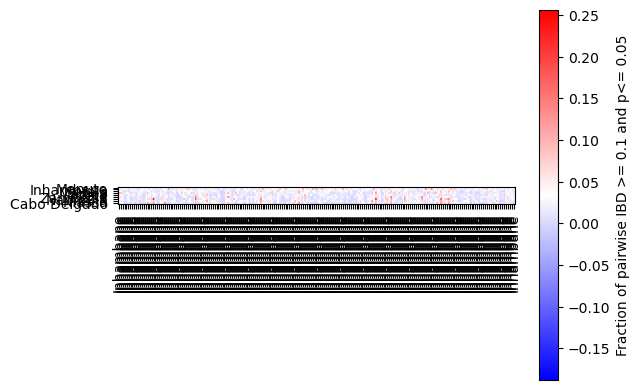

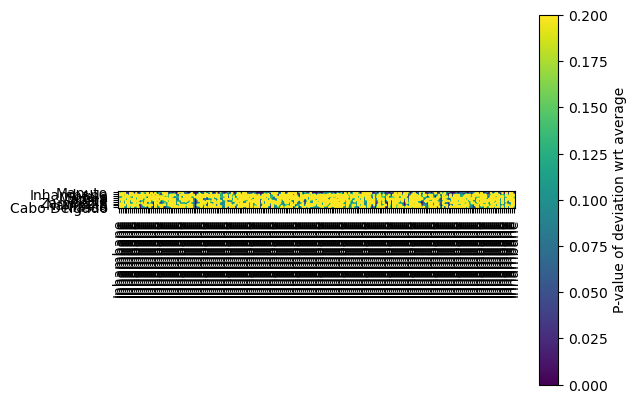

In [40]:
mask = react_meta
traveled_samples = list(ibd_res_meta[mask]['sampleID'])
destiny_samples = list(['Inhambane']*len(traveled_samples))
province_samples = list(ibd_res_meta[mask]['province'])
orig_dest_travels = [str(province_samples[i]) + '->' + str(destiny_samples[i]) \
                     for i in range(len(destiny_samples))]

max_p = .05
min_IBD = 0.1

category_label2 = 'province'
category_label = 'sampleID'
categories2 = ['Maputo', 'Inhambane', 'Sofala', 'Manica', \
               'Tete', 'Zambezia', 'Nampula', 'Niassa', 'Cabo Delgado']
categories = traveled_samples


ibdfrac_per_cat, ibdfrac_pval_per_cat, overall_high_ibd_frac = high_ibd_frac_per_cat(ibd_res, ibd_res_meta, category_label, \
                                                                                     category_label2, \
                                                                                     all_p_res = ibd_pval, ibd_pval_meta = ibd_pval_meta, \
                                                                                     min_IBD = min_IBD, max_p = max_p, \
                                                                                     categories = categories, categories2 = categories2, \
                                                                                     verbose = True, perm_pval = False)
show_ibd_frac_per_cat(ibdfrac_per_cat, overall_high_ibd_frac, \
                      ibdfrac_pval_per_cat, min_IBD = min_IBD, \
                      max_p = max_p, fontsize = 10, xrotation = 90, \
                     xticks = destiny_samples)

In [107]:
ibdfrac_per_cat

,N1852388_1_S78,N1852392_8_S137_L001,N1922384_1_S4_L001,N1922396_4_S161_L001,N1922411_4_S134_L001,N1922431_2_S97_L001,N1922467_1_S3,N1922471_8_S285_L001,N1922491_6_S168,N1922495_4_S274,...,N2039552_S167,N2039568_1_S251_L001,N2039678_7_S202,N2039681_7_S123_L001,N2084421_9_S262,N2084423_3_S270,N2084424_S164,N2084428_8_S170,N2084593_3_S172,N2084595_7_S278
Maputo,0.041074,0.026856,0.018957,0.030016,0.033175,0.020537,0.006319,0.020537,0.044234,0.006319,...,0.026856,0.023697,0.034755,0.012638,0.012638,0.022117,0.015798,0.017378,0.047393,0.009479
Inhambane,0.021918,0.008219,0.027397,0.035616,0.052055,0.005479,0.013699,0.019178,0.060274,0.016438,...,0.032877,0.010959,0.060274,0.030137,0.013699,0.019178,0.000000,0.032877,0.019178,0.010959
Sofala,0.036585,0.024390,0.012195,0.000000,0.012195,0.012195,0.012195,0.012195,0.024390,0.024390,...,0.036585,0.024390,0.000000,0.000000,0.000000,0.036585,0.048780,0.012195,0.012195,0.000000
Manica,0.113924,0.088608,0.025316,0.012658,0.037975,0.037975,0.000000,0.037975,0.025316,0.000000,...,0.050633,0.025316,0.012658,0.025316,0.000000,0.037975,0.037975,0.012658,0.050633,0.000000
Tete,0.031579,0.052632,0.010526,0.010526,0.000000,0.021053,0.000000,0.031579,0.000000,0.000000,...,0.021053,0.021053,0.000000,0.010526,0.000000,0.010526,0.031579,0.021053,0.021053,0.010526
Zambezia,0.024096,0.072289,0.024096,0.012048,0.012048,0.060241,0.000000,0.024096,0.012048,0.012048,...,0.060241,0.024096,0.012048,0.024096,0.000000,0.048193,0.060241,0.048193,0.036145,0.036145
Nampula,0.011111,0.044444,0.055556,0.000000,0.011111,0.044444,0.000000,0.000000,0.011111,0.000000,...,0.033333,0.022222,0.000000,0.011111,0.000000,0.066667,0.044444,0.000000,0.033333,0.022222
Niassa,0.034884,0.023256,0.011628,0.011628,0.000000,0.023256,0.000000,0.011628,0.011628,0.011628,...,0.069767,0.011628,0.000000,0.000000,0.000000,0.034884,0.046512,0.011628,0.046512,0.011628
Cabo Delgado,0.034091,0.034091,0.034091,0.000000,0.000000,0.034091,0.000000,0.011364,0.000000,0.000000,...,0.022727,0.022727,0.000000,0.034091,0.000000,0.011364,0.034091,0.022727,0.000000,0.011364


In [41]:
#Fraction of cases with IBD larger with local population than with Inhambane
print("Fraction of cases with IBD larger with local population than with Inhambane")
print(np.mean(ibdfrac_per_cat.loc['Maputo'] - ibdfrac_per_cat.loc['Inhambane'] > 0))
print(np.sum(ibdfrac_per_cat.loc['Maputo'] - ibdfrac_per_cat.loc['Inhambane'] > 0))
print("Fraction of cases with IBD larger with local population than with Zambezia")
print(np.mean(ibdfrac_per_cat.loc['Maputo'] - ibdfrac_per_cat.loc['Zambezia'] > 0))

Fraction of cases with IBD larger with local population than with Inhambane
0.391304347826087
81
Fraction of cases with IBD larger with local population than with Zambezia
0.6473429951690821


In [42]:
#Generating variables specifying if a sample has higher IBD with another province than with Maputo
data_local_vs_imps = pd.DataFrame({'sampleID' : traveled_samples})
for prov in categories2:
    data_local_vs_imps['est_imp_'+prov] = np.array(ibdfrac_per_cat.loc['Maputo'] - ibdfrac_per_cat.loc[prov] < 0, dtype = int)

In [43]:
#Merging data with travel reports and creating variables to select samples from each travel destination
trav_ibdcomp = pd.merge(import_data[['sampleID', 'travel', 'travel_prov']], data_local_vs_imps, \
         on = 'sampleID', how = 'left')

for prov in categories2:
    trav_ibdcomp['travel_' + prov] = trav_ibdcomp['travel_prov'] == prov

In [44]:
#Factor analysis to associate travel destinations with IBD comparisons
all_tables = []
for prov in categories2:
    print(prov)
    table_trav_imp = tables.labels_2d(trav_ibdcomp, 'travel_' + prov, 'est_imp_'+prov)
    print(table_trav_imp)
    stat, p, dof, expected = chi2_contingency(table_trav_imp)
    print("p-value:", p)
    print()
    print("-------")
    print()
    all_tables.append(table_trav_imp)
    

Maputo
         0
False  197
True    10
p-value: 1.0

-------

Inhambane
        1   0
False  78  70
True   48  11
p-value: 0.00025673628082687497

-------

Sofala
           0     1
False  133.0  73.0
True     1.0   0.0
p-value: 1.0

-------

Manica
           0     1
False  140.0  66.0
True     0.0   1.0
p-value: 0.7055914178487008

-------

Tete
         0   1
False  153  54
p-value: 1.0

-------

Zambezia
         0   1
False  126  66
True     8   7
p-value: 0.49712492863755875

-------

Nampula
         0   1
False  134  68
True     1   4
p-value: 0.09418103385846419

-------

Niassa
         0   1
False  138  69
p-value: 1.0

-------

Cabo Delgado
           0     1
False  137.0  69.0
True     0.0   1.0
p-value: 0.731662060369097

-------



In [45]:
pd.concat(all_tables)

,0,1
False,197.0,NaN
True,10.0,NaN
False,70.0,78.0
True,11.0,48.0
False,133.0,73.0
True,1.0,0.0
False,140.0,66.0
True,0.0,1.0
False,153.0,54.0
False,126.0,66.0


### Odds ratio analysis

### Firth logistic regressions

In [38]:
def set_x_for_firth_logist_reg(data, factor, data_type = 'categorical', verbose = True, \
                              feature_ref = None):
    """
    This method returns the predictor variables for a firth logistic regression. 
    
    Parameters:
    -----------
    data: pd.DataFrame
        The dataframe used for the firth regression. 
    factor: str or list
        The name (univariate analysis) or list of names (for a multivariate
        analysis) of the variables from data to be included in the firth 
        logistic regression. 
    data_type: str or list
        The type (for a univariate analysis) or list of types (for a 
        multivariate analysis) of the data variables. They can be 
        categorical ('categ' or 'categorical') or continuous ('cont' 
        or 'continuous'). 
    verbose: bool
        If True, some text is printed in the process. 
    feature_ref: str or list
        The name (univariate analysis) or list of names (for a multivariate
        analysis) of the feature of each variable to be used as reference in 
        the firth logistic regression. 
    
    Returns:
    --------
    x: np.array
        An array of the predictor variables for the fith logistic regression. 
    feature_names: list
        The list of variable names to be shown in the modelling output. 
    """
    if (type(factor) is str) & (type(data_type) is str):
        if data_type in ['categ', 'categorical']: 
            if feature_ref is None:
                feature_names = data[factor].unique()[:-1].tolist()
                ref_name = data[factor].unique()[-1]
            elif (type(feature_ref) is str) or np.isfinite(feature_ref):
                all_feature_names = data[factor].unique()
                feature_names = all_feature_names[all_feature_names != feature_ref].tolist() #TODO test
                ref_name = feature_ref
            else: 
                print("WARNING: wrong type of feature_ref", type(feature_ref), factor)
                print("feature_ref not used")
                pdb.set_trace()
                feature_names = data[factor].unique()[:-1].tolist()
                ref_name = data[factor].unique()[-1]
            if verbose: 
                print("Reference value:", ref_name)
            xlist = []
            for feature in feature_names:
                xlist.append(data[factor] == feature)
                x = np.array(xlist).T
        elif data_type in ['continuous', 'cont']:
            feature_names = [factor]
            x = np.array([data[factor]]).T
    elif (type(factor) is list) & (type(data_type) is list):
        x, feature_names = set_x_for_multi_firth_logist_reg(data, factor, data_type, \
                                                            feature_refs = feature_ref)
    else: 
        print("ERROR: wrong format of factor and data_type:", type(factor), type(data_type))
        return 1
    return x, feature_names

In [39]:
def set_x_for_multi_firth_logist_reg(data, factor_list, data_types, feature_refs = None):
    """
    This method returns the predictor variables and names for a multivariate firth 
    logistic regression. 
    
    Parameters:
    -----------
    data: pd.DataFrame
        The dataframe used for the firth regression. 
    factor_list: list
        The list of names of the variables from data to be included in the 
        multivariate firth logistic regression. 
    data_types: list
        The list of types of the data variables. They can be categorical 
        ('categ' or 'categorical') or continuous ('cont' or 'continuous'). 
    feature_refs: list
        list of the features to be used as reference for each factor. 
    
    Returns:
    --------
    x: np.array
        An array of the predictor variables for the fith logistic regression. 
    feature_names: list
        The list of variable names to be shown in the modelling output. 
    """
    feature_ref = None
    if feature_refs is not None:
        feature_ref = feature_refs[0]
    x, feature_names = set_x_for_firth_logist_reg(data, factor_list[0], data_type = data_types[0], \
                                                 feature_ref = feature_ref)
    for i, factor in enumerate(factor_list_multi[1:]): 
        feature_ref = None
        if feature_refs is not None:
            feature_ref = feature_refs[i + 1]
        x2, feature_names2 = set_x_for_firth_logist_reg(data, factor, data_type = data_types[i + 1], \
                                                       feature_ref = feature_ref)
        x = np.concatenate((x, x2), axis = 1)
        feature_names = feature_names + feature_names2
    return x, feature_names

In [40]:
def firth_logist_reg(data, x, y, data_type = 'categorical', verbose = False, clean_data = True, \
                    feature_ref = None):
    """
    This method performs a univariate or multivariate firth logistic regression and returns 
    the odds ratio and p-value statistics. 
    
    Parameters: 
    -----------
    data: pd.DataFrame
        The dataframe used for the firth regression.
    x: str or list
        The name (univariate analysis) or list of names (for a multivariate
        analysis) of the predictor variables from data to be included in the firth 
        logistic regression. 
    data_type: str or list
        The type (for a univariate analysis) or list of types (for a multivariate analysis) 
        of the predictor variables. They can be categorical ('categ' or 'categorical') or 
        continuous ('cont' or 'continuous'). 
    y: str
        The name of the variable from data to be used as response variable. 
    verbose: bool
        If True, if prints the output of the model. 
    clean_data: bool
        If True, the data is cleaned to that only data without missings is included. This is 
        only implemented for the univariate analysis, so previous cleaning needs to be 
        performed beforehand for a multivariate analysis. 
    feature_ref: str or list
        The name (univariate analysis) or list of names (for a multivariate
        analysis) of the feature of each variable to be used as reference in 
        the firth logistic regression. 
        
    Returns:
    --------
    odds_ratio: np.array
        An array with all the odd ratios obtained. 
    odds_ci: np.array
        An 2D-array with all the CI of the odd ratios obtained. 
    p_vals: np.array
        An array with all the p-values obtained. 
    feature_names: list
        A list of the feature names corresponding to the obtained statistics.
    """
    fl = FirthLogisticRegression()
    if clean_data:
        data_mask = data[y].notnull()&data[x].notnull()
        data_f = data[data_mask]
    else: 
        data_f = data
    y = data_f[y]
    x, feature_names = set_x_for_firth_logist_reg(data_f, x, data_type = data_type, \
                                                  verbose = verbose, feature_ref = feature_ref)
    fl.fit(x, y)
    odds_ratio = np.exp(fl.coef_)
    odds_ci = np.exp(fl.ci_[:-1])
    p_vals = fl.pvals_
    if verbose: 
        fl.summary(xname = feature_names)
        print("odds ratio:",odds_ratio)
        print("odds 95%CI:",odds_ci)
    return odds_ratio, odds_ci, p_vals, feature_names

In [41]:
def make_odds_res_table(all_odds, all_odds_CI, all_p_vals, all_names):
    """
    This method makes a pd.DataFrame of the odds ratio and p-value 
    results of a univariate analysis. 
    
    Parameters: 
    -----------
    odds_ratio: np.array
        An array with all the odd ratios obtained. 
    odds_ci: np.array
        An 2D-array with all the CI of the odd ratios obtained. 
    p_vals: np.array
        An array with all the p-values obtained. 
    feature_names: list
        A list of the feature names corresponding to the obtained statistics.
        
    Returns:
    --------
    results_table: pd.DataFrame
        Data frame of the results
    """
    results_table = pd.DataFrame({"Odds ratio (95%CI)" : [], 
                             "P-value" : []})

    for i, factor in enumerate(all_names):
        for j, name in enumerate(all_names[factor]):
            results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
                                                            str(round(all_odds_CI[factor][j][0], 2)) + ", " + \
                                                            str(round(all_odds_CI[factor][j][1], 2)) + ")" 
            results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))
        
    return results_table

In [84]:
def make_all_univ_regressions(import_data, factor_list, y, feature_ref = None):
    """
    This method performs all the univariate analyses for all 
    factors. 
    
    Parameters: 
    -----------
    import_data: pd.DataFrame
        The dataframe used for the firth regressions.
    factor_list: list
        The list of names of the variables from data to be included in the 
        multivariate firth logistic regression. 
    y: str
        The name of the variable from data to be used as response variable. 
    feature_ref: str or list
        The name (univariate analysis) or list of names (for a multivariate
        analysis) of the feature of each variable to be used as reference in 
        the firth logistic regression.
    
    Returns:
    --------
    all_odds: list
        List of all odds ratio obtained for all factors. 
    all_odds_CI: list
        List of all odds ratio CI obtained for all factors. 
    all_p_vals: list
        List of all p-values obtained for all factors. 
    all_names: list
        List of all the feature names obtained for all factors.     
    """
    all_odds = {}
    all_odds_CI = {}
    all_p_vals = {}
    all_names = {}
    
    for i, factor in enumerate(factor_list): 
        if factor in ['district', 'season', 'sex', 'pregnancy', 'occupation_simp', \
                      'travel_prov', 'polyclonal', 'naive_polyclonal', 'age_cat']:
            data_type = 'categorical'
        elif factor in ['age', 'logdens', 'eCOI', 'naive_coi', 'prob_polyclonal']:
            data_type = 'cont'
        else:
            print("WARNING: missed factor " + factor)

        if feature_ref is None:
            feat_ref = None
        else:
            feat_ref = feature_ref[i]
        odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(import_data, factor, y, \
                                                                      data_type = data_type, \
                                                                      verbose = False, \
                                                                     feature_ref = feat_ref)
        all_odds[factor] = odds_ratio
        all_odds_CI[factor] = odds_ci
        all_p_vals[factor] = p_vals
        all_names[factor] = feature_names
    
    return all_odds, all_odds_CI, all_p_vals, all_names

In [83]:
def rename_univ_names(all_names):
    """
    DOCUMENT
    """
    for factor in all_names:
        list_names = all_names[factor]
        for i in range(len(list_names)):
            if all_names[factor][i] == "Magude":
                all_names[factor][i] = "Magude"
            elif all_names[factor][i] == "Matutuine":
                all_names[factor][i] = "Matutuine"
            elif all_names[factor][i] == "dry":
                all_names[factor][i] = "Dry season"
            elif all_names[factor][i] == "rainy":
                all_names[factor][i] = "Rainy season"
            elif all_names[factor][i] == "Feminino":
                all_names[factor][i] = "Female"
            elif all_names[factor][i] == "Masculino":
                all_names[factor][i] = "Male"
            elif (all_names[factor][i] == "Nao") & (factor == 'pregnancy'):
                all_names[factor][i] = "Not pregnant"
            elif (all_names[factor][i] == "Sim") & (factor == 'pregnancy'):
                all_names[factor][i] = "Pregnant"
            elif all_names[factor][i] == "Domestica":
                all_names[factor][i] = "Domestic"
            elif all_names[factor][i] == "Nao aplicavel":
                all_names[factor][i] = "NA"
            elif all_names[factor][i] == "Estudante":
                all_names[factor][i] = "Student"
            elif all_names[factor][i] == "Agricultor":
                all_names[factor][i] = "Farmer"
            elif all_names[factor][i] == "Gaza":
                all_names[factor][i] = "Gaza"
            elif all_names[factor][i] == "Inhambane":
                all_names[factor][i] = "Inhambane"
            elif all_names[factor][i] == "Maputo":
                all_names[factor][i] = "Maputo"
            elif all_names[factor][i] == "Zambezia":
                all_names[factor][i] = "Zambezia"
            elif all_names[factor][i] == "Manica":
                all_names[factor][i] = "Manica"
            elif all_names[factor][i] == "Sofala":
                all_names[factor][i] = "Sofala"
            elif all_names[factor][i] == "Nampula":
                all_names[factor][i] = "Nampula"
            elif all_names[factor][i] == "Cabo Delgado":
                all_names[factor][i] = "Cabo Delgado"
            elif all_names[factor][i] == "Maputo City":
                all_names[factor][i] = "Maputo City"
            elif all_names[factor][i] == "age":
                all_names[factor][i] = "Age"
            elif all_names[factor][i] == "age_cat":
                all_names[factor][i] = "Age"
            elif all_names[factor][i] == "logdens":
                all_names[factor][i] = "log(density)"
            elif (all_names[factor][i] == 1) & (factor == 'polyclonal'):
                all_names[factor][i] = "eCOI>1.1"
            elif all_names[factor][i] == "naive_coi":
                all_names[factor][i] = "Naive COI"
            elif all_names[factor][i] == "prob_polyclonal":
                all_names[factor][i] = "Prob. polyclonal"
            elif (all_names[factor][i] == 1) & (factor == 'naive_polyclonal'):
                all_names[factor][i] = "Naive polyclonal"
    return all_names

In [82]:
def rename_multiv_names(all_names):
    """
    DOCUMENT
    """
    for i, name in enumerate(all_names):
        if all_names[i] == "Magude":
             all_names[i] = "Magude"
        elif all_names[i] == "Matutuine":
            all_names[i] = "Matutuine"
        elif all_names[i] == "dry":
            all_names[i] = "Dry season"
        elif all_names[i] == "rainy":
            all_names[i] = "Rainy season"
        elif all_names[i] == "Feminino":
            all_names[i] = "Female"
        elif all_names[i] == "Masculino":
            all_names[i] = "Male"
        elif all_names[i] == "Nao":
            all_names[i] = "Not pregnant"
        elif all_names[i] == "Sim":
            all_names[i] = "Pregnant"
        elif all_names[i] == "Domestica":
            all_names[i] = "Domestic"
        elif all_names[i] == "Nao aplicavel":
            all_names[i] = "NA"
        elif all_names[i] == "Estudante":
            all_names[i] = "Student"
        elif all_names[i] == "Agricultor":
            all_names[i] = "Farmer"
        elif all_names[i] == "Gaza":
            all_names[i] = "Gaza"
        elif all_names[i] == "Inhambane":
            all_names[i] = "Inhambane"
        elif all_names[i] == "Maputo":
            all_names[i] = "Maputo"
        elif all_names[i] == "Zambezia":
            all_names[i] = "Zambezia"
        elif all_names[i] == "Manica":
                all_names[i] = "Manica"
        elif all_names[i] == "Sofala":
            all_names[i] = "Sofala"
        elif all_names[i] == "Nampula":
            all_names[i] = "Nampula"
        elif all_names[i] == "Cabo Delgado":
            all_names[i] = "Cabo Delgado"
        elif all_names[i] == "Maputo City":
            all_names[i] = "Maputo City"
        elif all_names[i] == "age":
            all_names[i] = "Age"
        elif all_names[i] == "age_cat":
            all_names[i] = "Age"
        elif all_names[i] == "logdens":
            all_names[i] = "log(density)"
        elif (all_names[i] == 1) & ("eCOI>1.1" not in all_names): #assuming eCOI>1.1 goes first than Naive polyclonal
            all_names[i] = "eCOI>1.1"
        elif all_names[i] == "naive_coi":
            all_names[i] = "Naive COI"
        elif all_names[i] == "prob_polyclonal":
            all_names[i] = "Prob. polyclonal"
        elif all_names[i] == 1:
            all_names[i] = "Naive polyclonal"
    return all_names

In [86]:
factor2legend = {'district' : 'Residence district',
 'season' : 'Season',
 'sex' : 'Sex',
 'pregnancy' : 'Pregnancy',
 'occupation_simp' : 'Occupation',
 'travel_prov' : 'Travel province',
 'age' : 'Age',
 'age_cat' : 'Age',
 'logdens' : 'log(density)',
 'eCOI' : 'eCOI',
 'polyclonal' : 'Polyclonal',
 'naive_coi' : 'Naive COI',
 'prob_polyclonal' : 'Prob. polyclonal',
 'naive_polyclonal' : 'Naive polyclonal'}

def get_legend_factors(factor_list): 
    """
    DOCUMENT
    """
    factor_for_legend = [factor2legend[i] for i in factor_list]
    return factor_for_legend

In [87]:
def plot_univariade_odds(all_odds, all_odds_CI, all_p_vals, all_names, factor_list, \
                        save = False, out_filename = 'odds_univariate', \
                        save_path = "/home/apujol/isglobal/manuscripts/importation_relatedness/figs/", \
                        xlim = [0, 5], colours = None, fontsize = 12):
    """
    DOCUMENT
    """
    #defining colour palette
    num_variables = len(all_odds)
    colors_s = [cm.turbo(i/num_variables) for i in range(num_variables)]
    
    yticks = []
    f = 0
    ax = plt.subplot(111)
    ax.grid()
    for i, factor in enumerate(factor_list):
        err_top = all_odds_CI[factor][:,1] - all_odds[factor]
        err_bot = all_odds[factor] - all_odds_CI[factor][:,0]
        if colours is None:
            ax.errorbar(all_odds[factor], np.arange(f - len(all_odds[factor]), f)[::-1], xerr = np.array([err_bot, err_top]), \
                         marker = 'o', markersize = 8, label = factor, \
                         lw = 2, linestyle = 'none', color = cm.viridis(i/len(factor_list)))
        else:
            ax.errorbar(all_odds[factor], np.arange(f - len(all_odds[factor]), f)[::-1], xerr = np.array([err_bot, err_top]), \
                         marker = 'o', markersize = 8, label = factor, \
                         lw = 2, linestyle = 'none', color = colours[factor])
        f-= len(all_odds[factor])
        yticks += all_names[factor]
    ax.set_xlabel("Odds Ratio")
    ax.set_yticks(-1 - np.arange(-f), yticks, fontsize = fontsize)
    ax.set_xlim(xlim)
    ax.set_ylim(f - 1, 0)
    factor_for_legend = get_legend_factors(factor_list)
    ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.vlines(1, f - 1, 0, color = 'k')
    plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
    if save:
        plt.savefig(save_path + out_filename + ".pdf")
        plt.savefig(save_path + out_filename + ".png")
    plt.show()

### Univariate analysis

#### Risk factor associated to importation

In [66]:

factor2color = {'district': 'tab:blue', 
                'season': 'tab:orange', 
                'sex' : 'tab:purple', 
                'pregnancy' : 'tab:brown', 
                'occupation_simp' : 'tab:green', 
               'travel_prov' : 'tab:red', 
                'age' : 'tab:olive',
                'age_cat' : 'tab:olive',
                'logdens' : 'tab:cyan', 
                'eCOI' : cm.viridis(.1), 
                'polyclonal' : cm.viridis(.3), 
               'naive_coi' : cm.viridis(.5), 
                'prob_polyclonal' : cm.viridis(.7), 
                'naive_polyclonal' : cm.viridis(0.9)}

(array([ 7., 17., 12.,  8.,  8.,  1., 13.,  5.,  2., 13., 12.,  9., 15.,
         9.,  8.,  9.,  4.,  9.,  6.,  4.,  3.,  1.,  5.,  4.,  4.,  4.,
         5.,  0.,  0.,  1.,  1.,  1.,  2.,  0.,  0.,  1.,  3.,  0.,  0.,
         0.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
        26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.,
        52., 54., 56., 58., 60., 62., 64., 66., 68., 70., 72., 74., 76.,
        78., 80.]),
 <BarContainer object of 40 artists>)

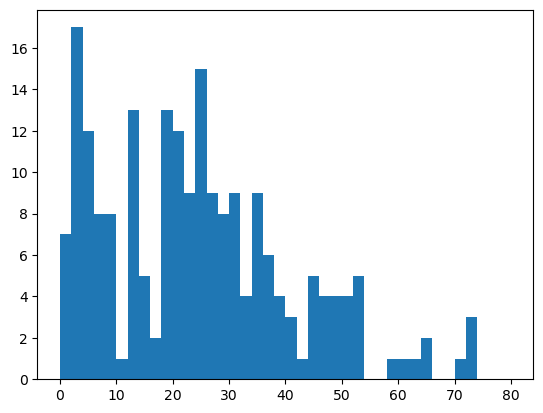

In [68]:
plt.hist(import_data['age'], 40, range = [0,80])

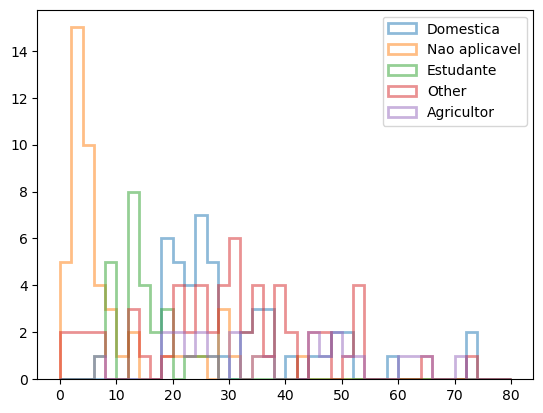

In [73]:
for occ in import_data['occupation_simp'].unique():
    mask = import_data['occupation_simp'] == occ
    plt.hist(import_data.loc[mask, 'age'], 40, range = [0,80], \
             alpha = .5, label = occ, histtype = 'step', lw = 2)
plt.legend()
plt.show()

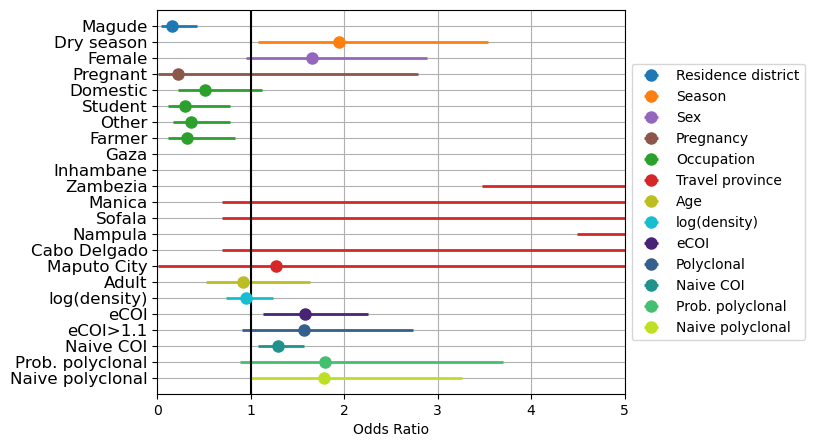

/tmp/ipykernel_44265/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.15 (0.04, 0.43)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_44265/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"0.15 (0.04, 0.43)",0.0001
Dry season,"1.95 (1.08, 3.53)",0.0265
Female,"1.65 (0.95, 2.88)",0.0746
Pregnant,"0.22 (0.0, 2.79)",0.2631
Domestic,"0.5 (0.22, 1.11)",0.0908
Student,"0.3 (0.11, 0.78)",0.0133
Other,"0.36 (0.17, 0.77)",0.0086
Farmer,"0.32 (0.11, 0.83)",0.0193
Gaza,"52.78 (6.31, 943.21)",0.0001
Inhambane,"78.11 (13.68, 865.04)",0.0


In [120]:
#input data
y = 'imported'
factor_list = ['district', 'season', 'sex', 'pregnancy', 'occupation_simp', 
               'travel_prov', 'age_cat', 'logdens', 'eCOI', 'polyclonal', 
               'naive_coi', 'prob_polyclonal', 'naive_polyclonal']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao', 'Nao aplicavel', 
               'Maputo', 'Minor', 'none', 'none', 0, 
               'none', 'none', 0]

#Run univariate analysis
all_odds, all_odds_CI, all_p_vals, all_names = make_all_univ_regressions(import_data, factor_list, y, \
                                                                        feature_ref = feature_refs)
all_names = rename_univ_names(all_names)
#Visualise results
plot_univariade_odds(all_odds, all_odds_CI, all_p_vals, all_names, factor_list, \
                    save = True, out_filename = 'odds_univariate_importation_agecat', \
                    save_path= save_path, xlim = [0,5], colours = factor2color, \
                    fontsize = 12)
#Make results table
results_table = make_odds_res_table(all_odds, all_odds_CI, all_p_vals, all_names)
results_table

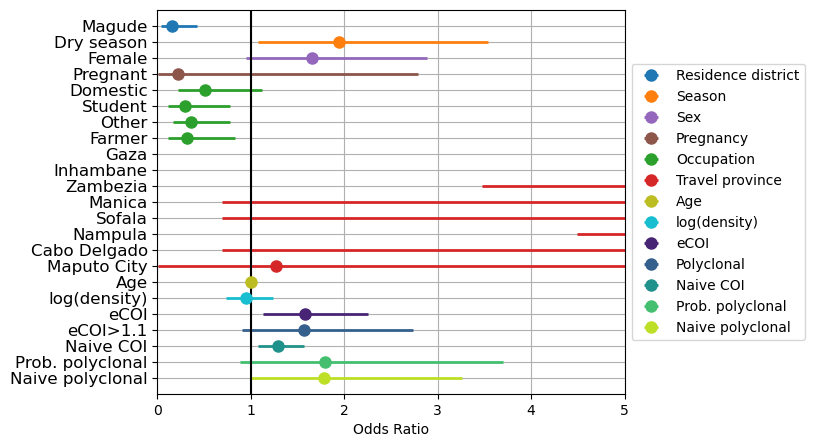

/tmp/ipykernel_44265/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.15 (0.04, 0.43)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_44265/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"0.15 (0.04, 0.43)",0.0001
Dry season,"1.95 (1.08, 3.53)",0.0265
Female,"1.65 (0.95, 2.88)",0.0746
Pregnant,"0.22 (0.0, 2.79)",0.2631
Domestic,"0.5 (0.22, 1.11)",0.0908
Student,"0.3 (0.11, 0.78)",0.0133
Other,"0.36 (0.17, 0.77)",0.0086
Farmer,"0.32 (0.11, 0.83)",0.0193
Gaza,"52.78 (6.31, 943.21)",0.0001
Inhambane,"78.11 (13.68, 865.04)",0.0


In [54]:
#input data
y = 'imported'
factor_list = ['district', 'season', 'sex', 'pregnancy', 'occupation_simp', 
               'travel_prov', 'age', 'logdens', 'eCOI', 'polyclonal', 
               'naive_coi', 'prob_polyclonal', 'naive_polyclonal']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao', 'Nao aplicavel', 
               'Maputo', 'none', 'none', 'none', 0, 
               'none', 'none', 0]

#Run univariate analysis
all_odds, all_odds_CI, all_p_vals, all_names = make_all_univ_regressions(import_data, factor_list, y, \
                                                                        feature_ref = feature_refs)
all_names = rename_univ_names(all_names)
#Visualise results
plot_univariade_odds(all_odds, all_odds_CI, all_p_vals, all_names, factor_list, \
                    save = True, out_filename = 'odds_univariate_importation', \
                    save_path= save_path, xlim = [0,5], colours = factor2color, \
                    fontsize = 12)
#Make results table
results_table = make_odds_res_table(all_odds, all_odds_CI, all_p_vals, all_names)
results_table

#### Risk factor associated to travel

In [123]:
import_data['travel'] = 2 - import_data['travel']

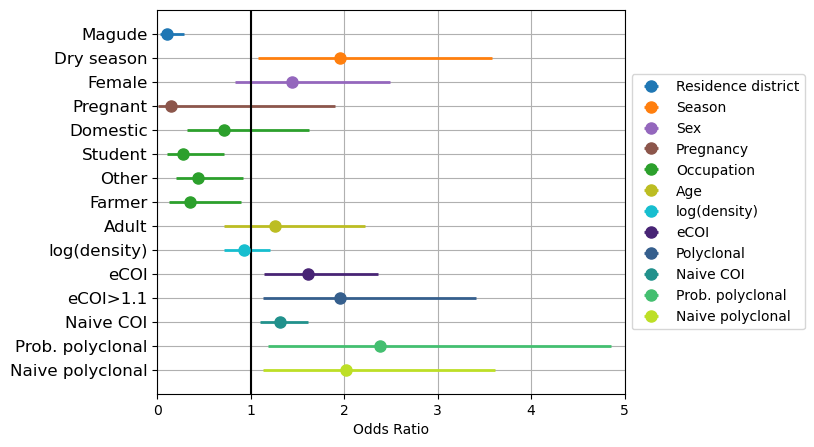

/tmp/ipykernel_44265/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.1 (0.03, 0.28)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_44265/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"0.1 (0.03, 0.28)",0.0
Dry season,"1.95 (1.08, 3.58)",0.027
Female,"1.44 (0.84, 2.49)",0.1905
Pregnant,"0.15 (0.0, 1.9)",0.153
Domestic,"0.72 (0.31, 1.62)",0.421
Student,"0.28 (0.1, 0.72)",0.008
Other,"0.43 (0.2, 0.92)",0.0286
Farmer,"0.34 (0.13, 0.9)",0.0289
Adult,"1.26 (0.71, 2.23)",0.4279
log(density),"0.93 (0.72, 1.21)",0.5878


In [124]:
#input data
y = 'travel'
factor_list = ['district', 'season', 'sex', 'pregnancy', 'occupation_simp', 
               'age_cat', 'logdens', 'eCOI', 'polyclonal', 
               'naive_coi', 'prob_polyclonal', 'naive_polyclonal']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao', 'Nao aplicavel', 
               'Minor', 'none', 'none', 0, 
               'none', 'none', 0]

#Run univariate analysis
all_odds, all_odds_CI, all_p_vals, all_names = make_all_univ_regressions(import_data, factor_list, y, \
                                                                        feature_ref = feature_refs)
all_names = rename_univ_names(all_names)
#Visualise results
plot_univariade_odds(all_odds, all_odds_CI, all_p_vals, all_names, factor_list, \
                    save = True, out_filename = 'odds_univariate_travel_agecat', \
                    save_path= save_path, colours = factor2color, \
                    fontsize = 12)
#Make results table
results_table = make_odds_res_table(all_odds, all_odds_CI, all_p_vals, all_names)
results_table

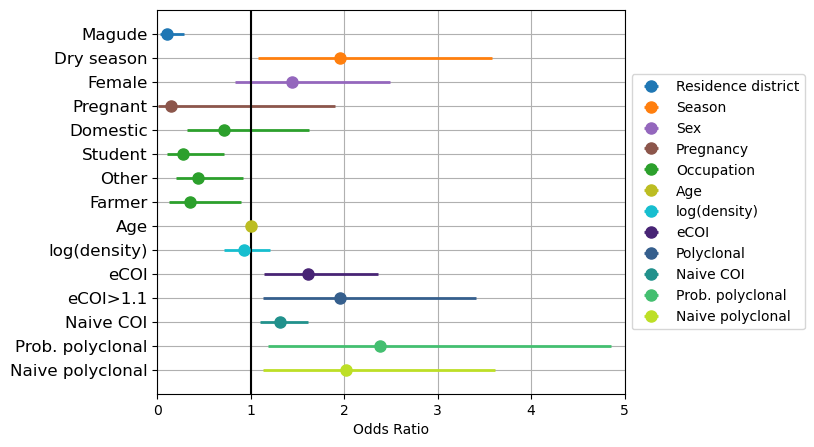

/tmp/ipykernel_44265/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.1 (0.03, 0.28)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_44265/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"0.1 (0.03, 0.28)",0.0
Dry season,"1.95 (1.08, 3.58)",0.027
Female,"1.44 (0.84, 2.49)",0.1905
Pregnant,"0.15 (0.0, 1.9)",0.153
Domestic,"0.72 (0.31, 1.62)",0.421
Student,"0.28 (0.1, 0.72)",0.008
Other,"0.43 (0.2, 0.92)",0.0286
Farmer,"0.34 (0.13, 0.9)",0.0289
Age,"1.01 (0.99, 1.02)",0.4526
log(density),"0.93 (0.72, 1.21)",0.5878


In [126]:
#input data
y = 'travel'
factor_list = ['district', 'season', 'sex', 'pregnancy', 'occupation_simp', 
               'age', 'logdens', 'eCOI', 'polyclonal', 
               'naive_coi', 'prob_polyclonal', 'naive_polyclonal']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao', 'Nao aplicavel', 
               'none', 'none', 'none', 0, 
               'none', 'none', 0]

#Run univariate analysis
all_odds, all_odds_CI, all_p_vals, all_names = make_all_univ_regressions(import_data, factor_list, y, \
                                                                        feature_ref = feature_refs)
all_names = rename_univ_names(all_names)
#Visualise results
plot_univariade_odds(all_odds, all_odds_CI, all_p_vals, all_names, factor_list, \
                    save = True, out_filename = 'odds_univariate_travel', \
                    save_path= save_path, colours = factor2color, \
                    fontsize = 12)
#Make results table
results_table = make_odds_res_table(all_odds, all_odds_CI, all_p_vals, all_names)
results_table

#### Risk factor associated to importation conditional to travelled

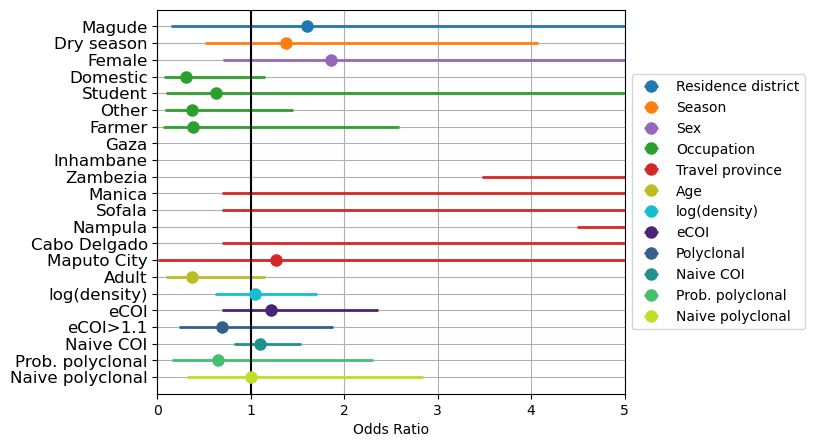

/tmp/ipykernel_44265/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.6 (0.15, 218.01)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_44265/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7472' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"1.6 (0.15, 218.01)",0.7472
Dry season,"1.38 (0.51, 4.08)",0.536
Female,"1.86 (0.7, 5.1)",0.213
Domestic,"0.3 (0.07, 1.15)",0.0806
Student,"0.63 (0.09, 7.13)",0.6672
Other,"0.37 (0.08, 1.45)",0.1527
Farmer,"0.38 (0.06, 2.58)",0.2854
Gaza,"52.78 (6.31, 943.21)",0.0001
Inhambane,"78.11 (13.68, 865.04)",0.0
Zambezia,"22.62 (3.47, 273.98)",0.0006


In [127]:
#input data
y = 'imported'
travel_mask = import_data['travel'] == 1
data = import_data[travel_mask]
factor_list = ['district', 'season', 'sex', 'occupation_simp', 'travel_prov',
               'age_cat', 'logdens', 'eCOI', 'polyclonal', 
               'naive_coi', 'prob_polyclonal', 'naive_polyclonal']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao aplicavel', 'Maputo', 
                'Minor', 'none', 'none', 0, 
               'none', 'none', 0]

#Run univariate analysis
all_odds, all_odds_CI, all_p_vals, all_names = make_all_univ_regressions(data, factor_list, y, \
                                                                        feature_ref = feature_refs)
all_names = rename_univ_names(all_names)
#Visualise results
plot_univariade_odds(all_odds, all_odds_CI, all_p_vals, all_names, factor_list, \
                    save = True, out_filename = 'odds_univariate_imp_travelled_agecat', \
                    save_path= save_path, colours = factor2color, xlim = [0,5], \
                    fontsize = 12)
#Make results table
results_table = make_odds_res_table(all_odds, all_odds_CI, all_p_vals, all_names)
results_table

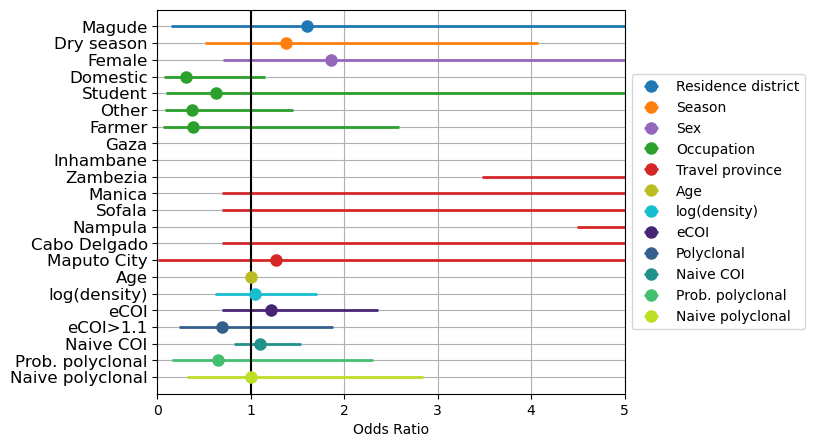

/tmp/ipykernel_44265/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.6 (0.15, 218.01)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_44265/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7472' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"1.6 (0.15, 218.01)",0.7472
Dry season,"1.38 (0.51, 4.08)",0.536
Female,"1.86 (0.7, 5.1)",0.213
Domestic,"0.3 (0.07, 1.15)",0.0806
Student,"0.63 (0.09, 7.13)",0.6672
Other,"0.37 (0.08, 1.45)",0.1527
Farmer,"0.38 (0.06, 2.58)",0.2854
Gaza,"52.78 (6.31, 943.21)",0.0001
Inhambane,"78.11 (13.68, 865.04)",0.0
Zambezia,"22.62 (3.47, 273.98)",0.0006


In [100]:
#input data
y = 'imported'
travel_mask = import_data['travel'] == 1
data = import_data[travel_mask]
factor_list = ['district', 'season', 'sex', 'occupation_simp', 'travel_prov',
               'age', 'logdens', 'eCOI', 'polyclonal', 
               'naive_coi', 'prob_polyclonal', 'naive_polyclonal']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao aplicavel', 'Maputo', 
                'none', 'none', 'none', 0, 
               'none', 'none', 0]

#Run univariate analysis
all_odds, all_odds_CI, all_p_vals, all_names = make_all_univ_regressions(data, factor_list, y, \
                                                                        feature_ref = feature_refs)
all_names = rename_univ_names(all_names)
#Visualise results
plot_univariade_odds(all_odds, all_odds_CI, all_p_vals, all_names, factor_list, \
                    save = True, out_filename = 'odds_univariate_imp_travelled', \
                    save_path= save_path, colours = factor2color, xlim = [0,5], \
                    fontsize = 12)
#Make results table
results_table = make_odds_res_table(all_odds, all_odds_CI, all_p_vals, all_names)
results_table

### Mutivariate firth logistic regression

Reference value: Matutuine
Reference value: rainy
Reference value: Masculino
Reference value: Nao aplicavel
Reference value: Minor
                  coef    std err     [0.025      0.975]     p-value
----------  ----------  ---------  ---------  ----------  ----------
Magude      -1.50052     0.606981  -2.85726   -0.432355   0.00447906
dry          0.44126     0.323688  -0.181305   1.06731    0.158917
Feminino     0.422952    0.330008  -0.212419   1.06466    0.19169
Domestica   -1.02632     0.564742  -2.13982    0.0411152  0.0595842
Estudante   -0.815942    0.552669  -1.90586    0.230182   0.123696
Other       -0.853093    0.507485  -1.85983    0.103517   0.0808266
Agricultor  -1.11411     0.636553  -2.37384    0.0814758  0.0680259
Adult        0.44746     0.457174  -0.410717   1.35735    0.310554
Intercept   -0.0854624   0.397457  -0.853904   0.683872   0.82558

Log-Likelihood: -119.1669
Newton-Raphson iterations: 5

odds ratio: [0.22301467 1.55466513 1.52646153 0.35832307 0.4422226  

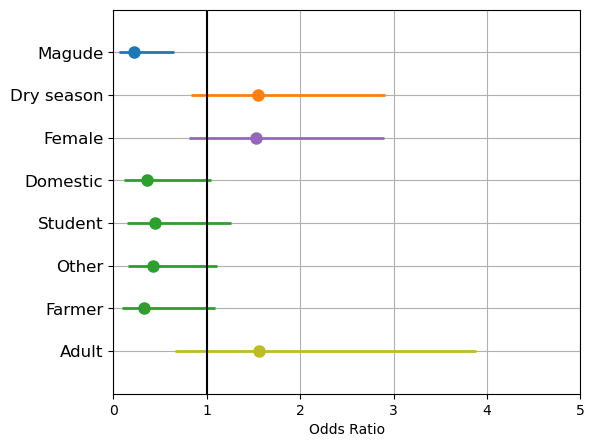

/tmp/ipykernel_44265/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.22 (0.06, 0.65)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_44265/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0045' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"0.22 (0.06, 0.65)",0.0045
Dry season,"1.55 (0.83, 2.91)",0.1589
Female,"1.53 (0.81, 2.9)",0.1917
Domestic,"0.36 (0.12, 1.04)",0.0596
Student,"0.44 (0.15, 1.26)",0.1237
Other,"0.43 (0.16, 1.11)",0.0808
Farmer,"0.33 (0.09, 1.08)",0.068
Adult,"1.56 (0.66, 3.89)",0.3106


In [150]:
y = "imported"
factor_list_multi = ['district', 'season', 'sex', 'occupation_simp', 'age_cat']
dtypes_list = ['categ', 'categ', 'categ', 'categ', 'categ']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao aplicavel', 'Minor']
fontsize = 12

data = import_data

odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(data, factor_list_multi, y, \
                                                                  data_type = dtypes_list, \
                                                                  verbose = True, clean_data = False, \
                                                             feature_ref = feature_refs)

feature_names = ['Magude', 'Dry season', 'Female',
 'Domestic', 'Student', 'Other', 'Farmer', 'Adult']

#Visualise results
colours = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', \
          'tab:green', 'tab:green', 'tab:green', 'tab:olive']

ax = plt.subplot(111)
ax.grid()
err_top = odds_ci[:,1] - odds_ratio
err_bot = odds_ratio - odds_ci[:,0]
for i, odd in enumerate(odds_ratio):
    ax.errorbar(odd, -i - 1, xerr = [[err_bot[i]],[err_top[i]]], marker = 'o', markersize = 8, \
                label = feature_names[i], lw = 2, linestyle = 'none', color = colours[i])
yticks = feature_names
ax.set_xlabel("Odds Ratio")
ax.set_yticks(np.linspace(-len(odds_ratio), -1, len(odds_ratio)), yticks[::-1], fontsize = fontsize)
ax.set_xlim(0,5)
ax.set_ylim(-len(odds_ratio) -1, 0)
#factor_for_legend = get_legend_factors(factor_list)
#ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
ax.vlines(1, -len(odds_ratio) - 1, 0, color = 'k')
plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
plt.savefig(save_path + "odds_ratio_multivariate_import_agecat.pdf")
plt.savefig(save_path + "odds_ratio_multivariate_import_agecat.png")
plt.show()


#Make results table
odds_ratio = {'all' : np.array(odds_ratio)}
odds_ci = {'all' : np.array(odds_ci)}
p_vals = {'all' : np.array(p_vals)}
feature_names = {'all' : np.array(feature_names)}
results_table = make_odds_res_table(odds_ratio, odds_ci, p_vals, feature_names)
results_table

Reference value: Matutuine
Reference value: rainy
Reference value: Masculino
Reference value: Nao aplicavel
                  coef    std err       [0.025      0.975]     p-value
----------  ----------  ---------  -----------  ----------  ----------
Magude      -1.49256    0.609377   -2.85125     -0.42043    0.00491561
dry          0.528196   0.329226   -0.103892     1.16706    0.0982129
Feminino     0.461691   0.334378   -0.182018     1.11381    0.159597
Domestica   -1.27352    0.504768   -2.26973     -0.31505    0.00896001
Estudante   -0.924083   0.555256   -2.02105      0.130614   0.0841548
Other       -1.1273     0.489856   -2.0968      -0.197723   0.0171899
Agricultor  -1.59543    0.658888   -2.92359     -0.367664   0.0103087
age          0.0268031  0.0115243   0.00520562   0.0498537  0.0145496
Intercept   -0.298898   0.408399   -1.09239      0.490367   0.456021

Log-Likelihood: -112.9911
Newton-Raphson iterations: 5

odds ratio: [0.2247975  1.69586979 1.5867542  0.27984368 0.3968

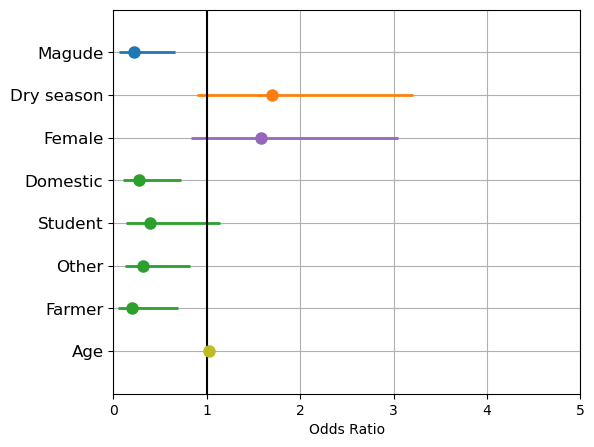

/tmp/ipykernel_44265/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.22 (0.06, 0.66)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_44265/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0049' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"0.22 (0.06, 0.66)",0.0049
Dry season,"1.7 (0.9, 3.21)",0.0982
Female,"1.59 (0.83, 3.05)",0.1596
Domestic,"0.28 (0.1, 0.73)",0.009
Student,"0.4 (0.13, 1.14)",0.0842
Other,"0.32 (0.12, 0.82)",0.0172
Farmer,"0.2 (0.05, 0.69)",0.0103
Age,"1.03 (1.01, 1.05)",0.0145


In [145]:
y = "imported"
factor_list_multi = ['district', 'season', 'sex', 'occupation_simp', 'age']
dtypes_list = ['categ', 'categ', 'categ', 'categ', 'cont']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao aplicavel', 'none']
fontsize = 12

data = import_data

odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(data, factor_list_multi, y, \
                                                                  data_type = dtypes_list, \
                                                                  verbose = True, clean_data = False, \
                                                             feature_ref = feature_refs)

feature_names = ['Magude', 'Dry season', 'Female',
 'Domestic', 'Student', 'Other', 'Farmer', 'Age']

#Visualise results
colours = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', \
          'tab:green', 'tab:green', 'tab:green', 'tab:olive']

ax = plt.subplot(111)
ax.grid()
err_top = odds_ci[:,1] - odds_ratio
err_bot = odds_ratio - odds_ci[:,0]
for i, odd in enumerate(odds_ratio):
    ax.errorbar(odd, -i - 1, xerr = [[err_bot[i]],[err_top[i]]], marker = 'o', markersize = 8, \
                label = feature_names[i], lw = 2, linestyle = 'none', color = colours[i])
yticks = feature_names
ax.set_xlabel("Odds Ratio")
ax.set_yticks(np.linspace(-len(odds_ratio), -1, len(odds_ratio)), yticks[::-1], fontsize = fontsize)
ax.set_xlim(0,5)
ax.set_ylim(-len(odds_ratio) -1, 0)
#factor_for_legend = get_legend_factors(factor_list)
#ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
ax.vlines(1, -len(odds_ratio) - 1, 0, color = 'k')
plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
plt.savefig(save_path + "odds_ratio_multivariate_import.pdf")
plt.savefig(save_path + "odds_ratio_multivariate_import.png")
plt.show()


#Make results table
odds_ratio = {'all' : np.array(odds_ratio)}
odds_ci = {'all' : np.array(odds_ci)}
p_vals = {'all' : np.array(p_vals)}
feature_names = {'all' : np.array(feature_names)}
results_table = make_odds_res_table(odds_ratio, odds_ci, p_vals, feature_names)
results_table

Reference value: Matutuine
Reference value: rainy
Reference value: Masculino
Reference value: Nao aplicavel
Reference value: Minor
                 coef    std err     [0.025      0.975]      p-value
----------  ---------  ---------  ---------  ----------  -----------
Magude      -1.9402     0.605543  -3.2942    -0.876902   0.000144625
dry          0.392723   0.330411  -0.24023    1.03648    0.218513
Feminino     0.196634   0.33224   -0.447049   0.838963   0.546976
Domestica   -0.73947    0.58214   -1.89339    0.360856   0.189597
Estudante   -0.809032   0.555779  -1.89733    0.251052   0.130974
Other       -0.819993   0.52062   -1.8615     0.156806   0.100804
Agricultor  -1.22763    0.641761  -2.50009   -0.0215984  0.0459595
Adult        0.64254    0.46491   -0.22652    1.57466    0.149393
Intercept    0.284967   0.404584  -0.488957   1.07839    0.47116

Log-Likelihood: -117.9363
Newton-Raphson iterations: 5

odds ratio: [0.14367458 1.48100829 1.21729824 0.4773669  0.44528878 0.4404345

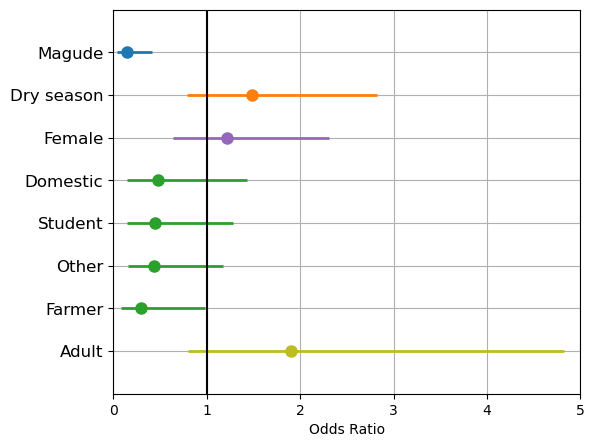

/tmp/ipykernel_44265/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.14 (0.04, 0.42)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_44265/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"0.14 (0.04, 0.42)",0.0001
Dry season,"1.48 (0.79, 2.82)",0.2185
Female,"1.22 (0.64, 2.31)",0.547
Domestic,"0.48 (0.15, 1.43)",0.1896
Student,"0.45 (0.15, 1.29)",0.131
Other,"0.44 (0.16, 1.17)",0.1008
Farmer,"0.29 (0.08, 0.98)",0.046
Adult,"1.9 (0.8, 4.83)",0.1494


In [152]:
y = "travel"
factor_list_multi = ['district', 'season', 'sex', 'occupation_simp', 'age_cat']
dtypes_list = ['categ', 'categ', 'categ', 'categ', 'categ']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao aplicavel', 'Minor']
fontsize = 12

data = import_data

odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(data, factor_list_multi, y, \
                                                                  data_type = dtypes_list, \
                                                                  verbose = True, clean_data = False, \
                                                             feature_ref = feature_refs)

feature_names = ['Magude', 'Dry season', 'Female',
 'Domestic', 'Student', 'Other', 'Farmer', 'Adult']

#Visualise results
colours = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', \
          'tab:green', 'tab:green', 'tab:green', 'tab:olive']

ax = plt.subplot(111)
ax.grid()
err_top = odds_ci[:,1] - odds_ratio
err_bot = odds_ratio - odds_ci[:,0]
for i, odd in enumerate(odds_ratio):
    ax.errorbar(odd, -i - 1, xerr = [[err_bot[i]],[err_top[i]]], marker = 'o', markersize = 8, \
                label = feature_names[i], lw = 2, linestyle = 'none', color = colours[i])
yticks = feature_names
ax.set_xlabel("Odds Ratio")
ax.set_yticks(np.linspace(-len(odds_ratio), -1, len(odds_ratio)), yticks[::-1], fontsize = fontsize)
ax.set_xlim(0,5)
ax.set_ylim(-len(odds_ratio) -1, 0)
#factor_for_legend = get_legend_factors(factor_list)
#ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
ax.vlines(1, -len(odds_ratio) - 1, 0, color = 'k')
plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
plt.savefig(save_path + "odds_ratio_multivariate_travel_agecat.pdf")
plt.savefig(save_path + "odds_ratio_multivariate_travel_agecat.png")
plt.show()


#Make results table
odds_ratio = {'all' : np.array(odds_ratio)}
odds_ci = {'all' : np.array(odds_ci)}
p_vals = {'all' : np.array(p_vals)}
feature_names = {'all' : np.array(feature_names)}
results_table = make_odds_res_table(odds_ratio, odds_ci, p_vals, feature_names)
results_table

Reference value: Matutuine
Reference value: rainy
Reference value: Masculino
Reference value: Nao aplicavel
                  coef    std err        [0.025      0.975]      p-value
----------  ----------  ---------  ------------  ----------  -----------
Magude      -1.96303    0.606394   -3.31757      -0.899153   0.000118953
dry          0.454572   0.333174   -0.182987      1.10464    0.158719
Feminino     0.209034   0.333053   -0.436214      0.853535   0.523403
Domestica   -0.705087   0.505858   -1.69384       0.265666   0.154649
Estudante   -0.87333    0.553566   -1.95751       0.185716   0.103299
Other       -0.865028   0.488232   -1.82819       0.0646455  0.0683532
Agricultor  -1.39227    0.641319   -2.67031      -0.187137   0.0232257
age          0.0216975  0.0114822   0.000196548   0.0446822  0.047891
Intercept    0.186288   0.411677   -0.602912      0.993445   0.638945

Log-Likelihood: -113.3058
Newton-Raphson iterations: 5

odds ratio: [0.14043268 1.57549868 1.23248728 0.494065

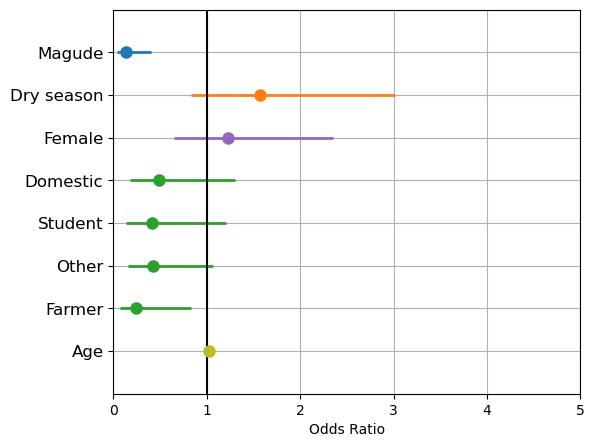

/tmp/ipykernel_44265/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.14 (0.04, 0.41)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_44265/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"0.14 (0.04, 0.41)",0.0001
Dry season,"1.58 (0.83, 3.02)",0.1587
Female,"1.23 (0.65, 2.35)",0.5234
Domestic,"0.49 (0.18, 1.3)",0.1546
Student,"0.42 (0.14, 1.2)",0.1033
Other,"0.42 (0.16, 1.07)",0.0684
Farmer,"0.25 (0.07, 0.83)",0.0232
Age,"1.02 (1.0, 1.05)",0.0479


In [147]:
y = "travel"
factor_list_multi = ['district', 'season', 'sex', 'occupation_simp', 'age']
dtypes_list = ['categ', 'categ', 'categ', 'categ', 'cont']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao aplicavel', 'none']
fontsize = 12

data = import_data

odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(data, factor_list_multi, y, \
                                                                  data_type = dtypes_list, \
                                                                  verbose = True, clean_data = False, \
                                                             feature_ref = feature_refs)

feature_names = ['Magude', 'Dry season', 'Female',
 'Domestic', 'Student', 'Other', 'Farmer', 'Age']

#Visualise results
colours = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', \
          'tab:green', 'tab:green', 'tab:green', 'tab:olive']

ax = plt.subplot(111)
ax.grid()
err_top = odds_ci[:,1] - odds_ratio
err_bot = odds_ratio - odds_ci[:,0]
for i, odd in enumerate(odds_ratio):
    ax.errorbar(odd, -i - 1, xerr = [[err_bot[i]],[err_top[i]]], marker = 'o', markersize = 8, \
                label = feature_names[i], lw = 2, linestyle = 'none', color = colours[i])
yticks = feature_names
ax.set_xlabel("Odds Ratio")
ax.set_yticks(np.linspace(-len(odds_ratio), -1, len(odds_ratio)), yticks[::-1], fontsize = fontsize)
ax.set_xlim(0,5)
ax.set_ylim(-len(odds_ratio) -1, 0)
#factor_for_legend = get_legend_factors(factor_list)
#ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
ax.vlines(1, -len(odds_ratio) - 1, 0, color = 'k')
plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
plt.savefig(save_path + "odds_ratio_multivariate_travel.pdf")
plt.savefig(save_path + "odds_ratio_multivariate_travel.png")
plt.show()


#Make results table
odds_ratio = {'all' : np.array(odds_ratio)}
odds_ci = {'all' : np.array(odds_ci)}
p_vals = {'all' : np.array(p_vals)}
feature_names = {'all' : np.array(feature_names)}
results_table = make_odds_res_table(odds_ratio, odds_ci, p_vals, feature_names)
results_table

Reference value: Matutuine
Reference value: rainy
Reference value: Masculino
Reference value: Nao aplicavel
Reference value: Minor
                 coef    std err     [0.025    0.975]    p-value
----------  ---------  ---------  ---------  --------  ---------
Magude       0.476713   1.91353   -2.42086   5.5808    0.715195
dry          0.323944   0.549498  -0.717378  1.45861   0.507345
Feminino     0.857766   0.572456  -0.23916   2.03333   0.125345
Domestica   -0.92515    1.07706   -3.33695   0.925965  0.340085
Estudante   -0.619673   1.09022   -2.64282   1.8338    0.547418
Other       -0.217063   1.08789   -2.6503    1.68211   0.781903
Agricultor  -0.174529   1.24472   -2.78471   2.13991   0.799999
Adult       -0.416578   1.09099   -2.38266   2.00726   0.674413
Intercept    1.50953    0.745962   0.136404  3.1067    0.0304565

Log-Likelihood: -43.8478
Newton-Raphson iterations: 9

odds ratio: [1.61077122 1.38256971 2.35788725 0.39647206 0.53812058 0.80487917
 0.8398528  0.65929912]
odd

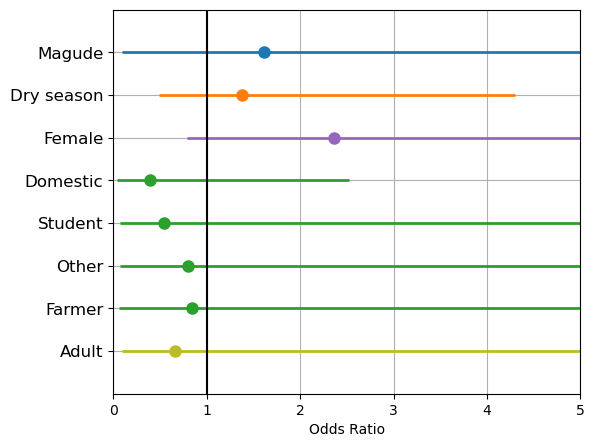

/tmp/ipykernel_44265/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.61 (0.09, 265.28)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_44265/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7152' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"1.61 (0.09, 265.28)",0.7152
Dry season,"1.38 (0.49, 4.3)",0.5073
Female,"2.36 (0.79, 7.64)",0.1253
Domestic,"0.4 (0.04, 2.52)",0.3401
Student,"0.54 (0.07, 6.26)",0.5474
Other,"0.8 (0.07, 5.38)",0.7819
Farmer,"0.84 (0.06, 8.5)",0.8
Adult,"0.66 (0.09, 7.44)",0.6744


In [154]:
#Conditional to travel

y = "imported"
factor_list_multi = ['district', 'season', 'sex', 'occupation_simp', 'age_cat']
dtypes_list = ['categ', 'categ', 'categ', 'categ', 'categ']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao aplicavel', 'Minor']
fontsize = 12

data = import_data[import_data['travel_prov'].notnull()]

odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(data, factor_list_multi, y, \
                                                                  data_type = dtypes_list, \
                                                                  verbose = True, clean_data = False, \
                                                             feature_ref = feature_refs)

feature_names = ['Magude', 'Dry season', 'Female',
 'Domestic', 'Student', 'Other', 'Farmer', 'Adult']

#Visualise results
colours = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', \
          'tab:green', 'tab:green', 'tab:green', 'tab:olive']

ax = plt.subplot(111)
ax.grid()
err_top = odds_ci[:,1] - odds_ratio
err_bot = odds_ratio - odds_ci[:,0]
for i, odd in enumerate(odds_ratio):
    ax.errorbar(odd, -i - 1, xerr = [[err_bot[i]],[err_top[i]]], marker = 'o', markersize = 8, \
                label = feature_names[i], lw = 2, linestyle = 'none', color = colours[i])
yticks = feature_names
ax.set_xlabel("Odds Ratio")
ax.set_yticks(np.linspace(-len(odds_ratio), -1, len(odds_ratio)), yticks[::-1], fontsize = fontsize)
ax.set_xlim(0,5)
ax.set_ylim(-len(odds_ratio) -1, 0)
#factor_for_legend = get_legend_factors(factor_list)
#ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
ax.vlines(1, -len(odds_ratio) - 1, 0, color = 'k')
plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
plt.savefig(save_path + "odds_ratio_multivariate_imp_travelled_agecat.pdf")
plt.savefig(save_path + "odds_ratio_multivariate_imp_travelled_agecat.png")
plt.show()


#Make results table
odds_ratio = {'all' : np.array(odds_ratio)}
odds_ci = {'all' : np.array(odds_ci)}
p_vals = {'all' : np.array(p_vals)}
feature_names = {'all' : np.array(feature_names)}
results_table = make_odds_res_table(odds_ratio, odds_ci, p_vals, feature_names)
results_table

Reference value: Matutuine
Reference value: rainy
Reference value: Masculino
Reference value: Nao aplicavel
                 coef    std err       [0.025      0.975]    p-value
----------  ---------  ---------  -----------  ----------  ---------
Magude       0.63181   1.9241     -2.26013      5.75203    0.668096
dry          0.517064  0.566096   -0.556126     1.68284    0.324547
Feminino     0.902668  0.585413   -0.218109     2.11443    0.111546
Domestica   -2.08068   0.896055   -3.96953     -0.412842   0.0131767
Estudante   -0.716679  1.13804    -2.84311      1.82051    0.506191
Other       -1.49016   0.970486   -3.52367      0.342145   0.112111
Agricultor  -1.64634   1.2169     -4.05283      0.702236   0.161712
age          0.034555  0.0229945  -0.00681636   0.0855807  0.10353
Intercept    1.07232   0.739914   -0.312277     2.64709    0.130623

Log-Likelihood: -38.513
Newton-Raphson iterations: 9

odds ratio: [1.8810113  1.67709633 2.46617399 0.12484501 0.48837148 0.22533753
 0.19275

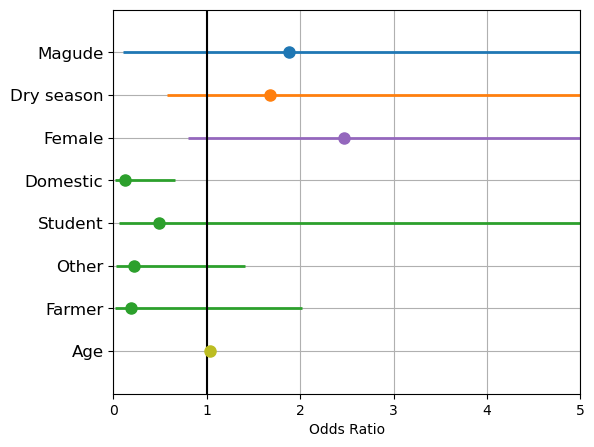

/tmp/ipykernel_44265/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.88 (0.1, 314.83)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_44265/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6681' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"1.88 (0.1, 314.83)",0.6681
Dry season,"1.68 (0.57, 5.38)",0.3245
Female,"2.47 (0.8, 8.28)",0.1115
Domestic,"0.12 (0.02, 0.66)",0.0132
Student,"0.49 (0.06, 6.17)",0.5062
Other,"0.23 (0.03, 1.41)",0.1121
Farmer,"0.19 (0.02, 2.02)",0.1617
Age,"1.04 (0.99, 1.09)",0.1035


In [106]:
#Conditional to travel

y = "imported"
factor_list_multi = ['district', 'season', 'sex', 'occupation_simp', 'age']
dtypes_list = ['categ', 'categ', 'categ', 'categ', 'cont']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao aplicavel', 'none']
fontsize = 12

data = import_data[import_data['travel_prov'].notnull()]

odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(data, factor_list_multi, y, \
                                                                  data_type = dtypes_list, \
                                                                  verbose = True, clean_data = False, \
                                                             feature_ref = feature_refs)

feature_names = ['Magude', 'Dry season', 'Female',
 'Domestic', 'Student', 'Other', 'Farmer', 'Age']

#Visualise results
colours = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', \
          'tab:green', 'tab:green', 'tab:green', 'tab:olive']

ax = plt.subplot(111)
ax.grid()
err_top = odds_ci[:,1] - odds_ratio
err_bot = odds_ratio - odds_ci[:,0]
for i, odd in enumerate(odds_ratio):
    ax.errorbar(odd, -i - 1, xerr = [[err_bot[i]],[err_top[i]]], marker = 'o', markersize = 8, \
                label = feature_names[i], lw = 2, linestyle = 'none', color = colours[i])
yticks = feature_names
ax.set_xlabel("Odds Ratio")
ax.set_yticks(np.linspace(-len(odds_ratio), -1, len(odds_ratio)), yticks[::-1], fontsize = fontsize)
ax.set_xlim(0,5)
ax.set_ylim(-len(odds_ratio) -1, 0)
#factor_for_legend = get_legend_factors(factor_list)
#ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
ax.vlines(1, -len(odds_ratio) - 1, 0, color = 'k')
plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
plt.savefig(save_path + "odds_ratio_multivariate_imp_travelled.pdf")
plt.savefig(save_path + "odds_ratio_multivariate_imp_travelled.png")
plt.show()


#Make results table
odds_ratio = {'all' : np.array(odds_ratio)}
odds_ci = {'all' : np.array(odds_ci)}
p_vals = {'all' : np.array(p_vals)}
feature_names = {'all' : np.array(feature_names)}
results_table = make_odds_res_table(odds_ratio, odds_ci, p_vals, feature_names)
results_table

Reference value: Matutuine
Reference value: rainy
Reference value: Masculino
Reference value: Nao aplicavel
Reference value: Minor
Reference value: Maputo
                    coef    std err     [0.025    0.975]      p-value
------------  ----------  ---------  ---------  --------  -----------
Magude        -0.84363     2.05846   -4.27233   4.94132   0.593162
dry            0.0266578   0.730439  -1.434     1.62588   0.751165
Feminino       1.05546     0.725319  -0.393212  2.66932   0.144498
Domestica      0.113424    1.15591   -2.40878   2.2235    0.717316
Estudante     -0.114613    1.43418   -3.09047   3.57545   0.792487
Other          1.00825     1.21532   -1.5668    3.38151   0.372287
Agricultor     1.20734     1.47053   -1.70945   4.24557   0.371444
Adult         -1.6805      1.26392   -4.30365   1.02185   0.198922
Gaza           3.73171     1.32664    1.41991   6.75934   0.000804106
Inhambane      4.11555     1.09344    2.26235   6.63559   1.60809e-06
Zambezia       2.64647     1.

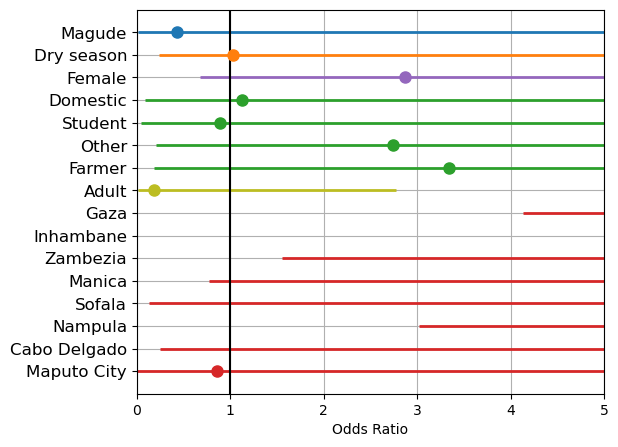

/tmp/ipykernel_44265/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.43 (0.01, 139.95)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_44265/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5932' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"0.43 (0.01, 139.95)",0.5932
Dry season,"1.03 (0.24, 5.08)",0.7512
Female,"2.87 (0.67, 14.43)",0.1445
Domestic,"1.12 (0.09, 9.24)",0.7173
Student,"0.89 (0.05, 35.71)",0.7925
Other,"2.74 (0.21, 29.42)",0.3723
Farmer,"3.34 (0.18, 69.8)",0.3714
Adult,"0.19 (0.01, 2.78)",0.1989
Gaza,"41.75 (4.14, 862.08)",0.0008
Inhambane,"61.29 (9.61, 761.73)",0.0


In [158]:
#Conditional to travel

y = "imported"
factor_list_multi = ['district', 'season', 'sex', 'occupation_simp', 'age_cat', 'travel_prov']
dtypes_list = ['categ', 'categ', 'categ', 'categ', 'categ', 'categ']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao aplicavel', 'Minor', 'Maputo']
fontsize = 12

data = import_data[import_data['travel_prov'].notnull()]

odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(data, factor_list_multi, y, \
                                                                  data_type = dtypes_list, \
                                                                  verbose = True, clean_data = False, \
                                                             feature_ref = feature_refs)

feature_names = ['Magude', 'Dry season', 'Female',
 'Domestic', 'Student', 'Other', 'Farmer', 'Adult', 'Gaza',
 'Inhambane',
 'Zambezia',
 'Manica',
 'Sofala',
 'Nampula',
 'Cabo Delgado',
 'Maputo City']

#Visualise results
colours = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', \
          'tab:green', 'tab:green', 'tab:green', 'tab:olive', \
          'tab:red', 'tab:red', 'tab:red', 'tab:red', 'tab:red', \
           'tab:red', 'tab:red', 'tab:red', ]

ax = plt.subplot(111)
ax.grid()
err_top = odds_ci[:,1] - odds_ratio
err_bot = odds_ratio - odds_ci[:,0]
for i, odd in enumerate(odds_ratio):
    ax.errorbar(odd, -i - 1, xerr = [[err_bot[i]],[err_top[i]]], marker = 'o', markersize = 8, \
                label = feature_names[i], lw = 2, linestyle = 'none', color = colours[i])
yticks = feature_names
ax.set_xlabel("Odds Ratio")
ax.set_yticks(np.linspace(-len(odds_ratio), -1, len(odds_ratio)), yticks[::-1], fontsize = fontsize)
ax.set_xlim(0,5)
ax.set_ylim(-len(odds_ratio) -1, 0)
#factor_for_legend = get_legend_factors(factor_list)
#ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
ax.vlines(1, -len(odds_ratio)-1, 0, color = 'k')
plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
plt.savefig(save_path + "odds_ratio_multivariate_imp_travelled_travprov_agecat.pdf")
plt.savefig(save_path + "odds_ratio_multivariate_imp_travelled_travprov_agecat.png")
plt.show()


#Make results table
odds_ratio = {'all' : np.array(odds_ratio)}
odds_ci = {'all' : np.array(odds_ci)}
p_vals = {'all' : np.array(p_vals)}
feature_names = {'all' : np.array(feature_names)}
results_table = make_odds_res_table(odds_ratio, odds_ci, p_vals, feature_names)
results_table

/home/apujol/anaconda3/envs/pyspatial/lib/python3.9/site-packages/firthlogist/firthlogist.py:375: ConvergenceWarning: Firth logistic regression failed to converge. Try increasing max_iter.
  _, null_loglik, _ = _firth_newton_raphson(


Reference value: Matutuine
Reference value: rainy
Reference value: Masculino
Reference value: Nao aplicavel
Reference value: Maputo
                    coef    std err      [0.025    0.975]     p-value
------------  ----------  ---------  ----------  --------  ----------
Magude        -0.181112   2.03898    -3.48899    5.70709   0.743287
dry            0.40998    0.75654    -1.12065    2.09896   0.49595
Feminino       1.29023    0.772009   -0.270642   3.19857   0.105386
Domestica     -2.02526    1.09744    -4.61257    0.119316  0.0561031
Estudante      0.0972841  1.63318    -3.27452    4.29198   0.832214
Other         -1.1407     1.20643    -3.79719    1.34129   0.311854
Agricultor    -1.31042    1.58628    -4.63844    1.83088   0.392464
age            0.0408032  0.0311102  -0.0193873  0.118664  0.188276
Gaza           3.42532    1.3013      1.14438    6.44372   0.00214078
Inhambane      3.90917    1.08309     2.07164    6.44884   5.0702e-06
Zambezia       3.06766    1.36111     0.6607

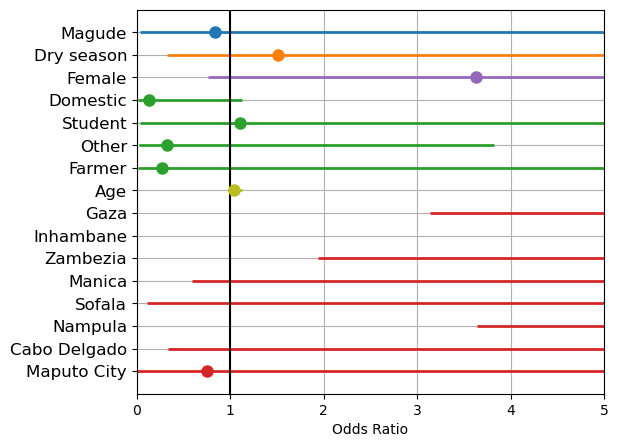

/tmp/ipykernel_44265/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.83 (0.03, 300.99)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_44265/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7433' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"0.83 (0.03, 300.99)",0.7433
Dry season,"1.51 (0.33, 8.16)",0.496
Female,"3.63 (0.76, 24.5)",0.1054
Domestic,"0.13 (0.01, 1.13)",0.0561
Student,"1.1 (0.04, 73.11)",0.8322
Other,"0.32 (0.02, 3.82)",0.3119
Farmer,"0.27 (0.01, 6.24)",0.3925
Age,"1.04 (0.98, 1.13)",0.1883
Gaza,"30.73 (3.14, 628.74)",0.0021
Inhambane,"49.86 (7.94, 631.97)",0.0


In [157]:
#Conditional to travel

y = "imported"
factor_list_multi = ['district', 'season', 'sex', 'occupation_simp', 'age', 'travel_prov']
dtypes_list = ['categ', 'categ', 'categ', 'categ', 'cont', 'categ']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao aplicavel', 'none', 'Maputo']
fontsize = 12

data = import_data[import_data['travel_prov'].notnull()]

odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(data, factor_list_multi, y, \
                                                                  data_type = dtypes_list, \
                                                                  verbose = True, clean_data = False, \
                                                             feature_ref = feature_refs)

feature_names = ['Magude', 'Dry season', 'Female',
 'Domestic', 'Student', 'Other', 'Farmer', 'Age', 'Gaza',
 'Inhambane',
 'Zambezia',
 'Manica',
 'Sofala',
 'Nampula',
 'Cabo Delgado',
 'Maputo City']

#Visualise results
colours = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', \
          'tab:green', 'tab:green', 'tab:green', 'tab:olive', \
          'tab:red', 'tab:red', 'tab:red', 'tab:red', 'tab:red', \
           'tab:red', 'tab:red', 'tab:red', ]

ax = plt.subplot(111)
ax.grid()
err_top = odds_ci[:,1] - odds_ratio
err_bot = odds_ratio - odds_ci[:,0]
for i, odd in enumerate(odds_ratio):
    ax.errorbar(odd, -i - 1, xerr = [[err_bot[i]],[err_top[i]]], marker = 'o', markersize = 8, \
                label = feature_names[i], lw = 2, linestyle = 'none', color = colours[i])
yticks = feature_names
ax.set_xlabel("Odds Ratio")
ax.set_yticks(np.linspace(-len(odds_ratio), -1, len(odds_ratio)), yticks[::-1], fontsize = fontsize)
ax.set_xlim(0,5)
ax.set_ylim(-len(odds_ratio) -1, 0)
#factor_for_legend = get_legend_factors(factor_list)
#ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
ax.vlines(1, -len(odds_ratio)-1, 0, color = 'k')
plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
plt.savefig(save_path + "odds_ratio_multivariate_imp_travelled_travprov.pdf")
plt.savefig(save_path + "odds_ratio_multivariate_imp_travelled_travprov.png")
plt.show()


#Make results table
odds_ratio = {'all' : np.array(odds_ratio)}
odds_ci = {'all' : np.array(odds_ci)}
p_vals = {'all' : np.array(p_vals)}
feature_names = {'all' : np.array(feature_names)}
results_table = make_odds_res_table(odds_ratio, odds_ci, p_vals, feature_names)
results_table

### GLM multivariate

In [249]:
import statsmodels.api as sm

In [269]:
multiv_model = smf.glm("imported ~ district + season + sex + occupation_simp + age", \
                       data = import_data, family=sm.families.Binomial())
model_res = multiv_model.fit()
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               imported   No. Observations:                  207
Model:                            GLM   Df Residuals:                      198
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -125.35
Date:                Sat, 26 Oct 2024   Deviance:                       250.70
Time:                        13:48:57   Pearson chi2:                     208.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1416
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -2.6370      0.962     -2.743      0.006      -4.522      -0.752
district[T.Matutuine]                1.6657      0.649      2.567      0.010       0.394       2.938
season[T.rainy]                     -0.5530      0.331     -1.670      0.095      -1.202       0.096
sex[T.Masculino]                    -0.4833      0.338     -1.430      0.153      -1.146       0.179
occupation_simp[T.Domestica]         0.3532      0.592      0.597      0.550      -0.806       1.513
occupation_simp[T.Estudante]         0.7157      0.735      0.974      0.330      -0.725       2.157
occupation_simp[T.Nao aplicavel]     1.6877      0.668      2.528      0.011       0.379       2.996
occupation_simp[T.Other]             0.5097      0.554      0.919      0.358      -0.577       1.596
age                                  0.0284      0.012      2.437      0.015       0.006       0.051
====================================================================================================
"""

In [251]:
odds = np.exp(model_res.params)
odds_CI = np.exp(model_res.conf_int())
print(odds, odds_CI)

Intercept                0.120000
district[T.Matutuine]    7.535461
dtype: float64                               0          1
Intercept              0.036232   0.397442
district[T.Matutuine]  2.196036  25.857117
